In [1]:
import time
import hydroeval as he
import json
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import sys
from datetime import date
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from scipy.stats import sem
from scipy.stats import linregress
from sklearn.metrics import mean_squared_error
import math
from scipy import stats
import statistics
import os
from scipy.stats import gumbel_r, norm
from scipy.stats import gumbel_r
from scipy.stats import kurtosis
from scipy.stats import norm, laplace


### **20 stations Louisiana (Wet)**

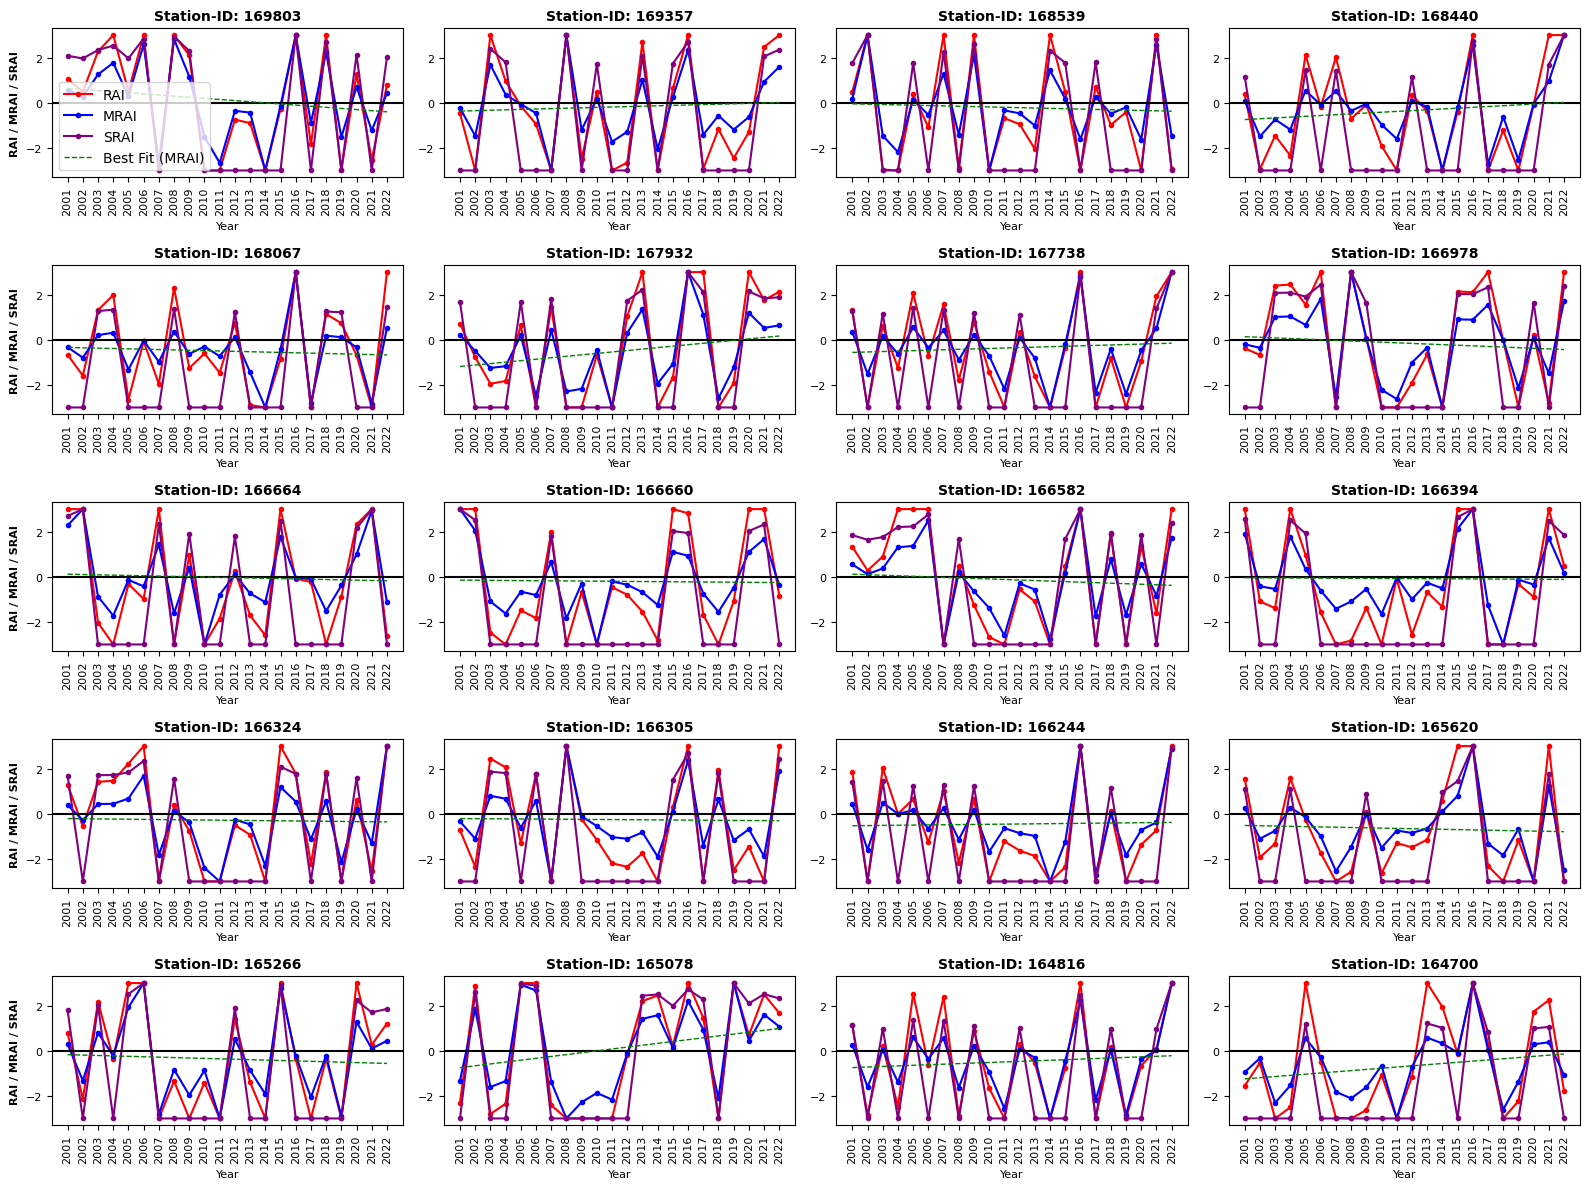

In [26]:

# Step 1: Load the data from the CSV file
file_path = os.path.join('Data', 'anomalyAllnew.csv')
data = pd.read_csv(file_path)

# Step 2: Define the list of specific IDs to be plotted
selected_ids = [169803, 169357, 168539, 168440, 168067, 167932, 167738, 166978, 
                166664, 166660, 166582, 166394, 166324, 166305, 166244, 165620, 
                165266, 165078, 164816, 164700]

# Step 3: Filter data to include only the fields needed and the selected IDs
filtered_data = data[['ID', 'Year', 'pre24h_RAI', 'pre24h_MRAI', 'pre24h_SRAI']].loc[data['ID'].isin(selected_ids)]

# Step 4: Create subplots (5 rows and 4 columns)
fig, axs = plt.subplots(5, 4, figsize=(16, 12))  # 5x4 grid, adjust figsize to fit subplots
axs = axs.flatten()  # Flatten to easily iterate over subplots

# Step 5: Loop through each unique ID and plot the data for each ID in a separate subplot
for i, id_value in enumerate(selected_ids):
    id_data = filtered_data[filtered_data['ID'] == id_value]
    
    # Extract data for plotting
    years = id_data['Year']
    pre24h_RAI = id_data['pre24h_RAI']
    pre24h_MRAI = id_data['pre24h_MRAI']
    pre24h_SRAI = id_data['pre24h_SRAI']
    
    # Plot 'pre24h_RAI' in red and 'pre24h_MRAI' in blue
    axs[i].plot(years, pre24h_RAI, color='red', label='RAI', marker='o', markersize=3)
    axs[i].plot(years, pre24h_MRAI, color='blue', label='MRAI', marker='o', markersize=3)
    axs[i].plot(years, pre24h_SRAI, color='purple', label='SRAI', marker='o', markersize=3)

    # Add a thick black horizontal line at y=0
    axs[i].axhline(0, color='black', linewidth=1.5)

    # Calculate and plot the line of best fit for 'pre24h_MRAI'
    if not pre24h_MRAI.isnull().all():  # Check for non-null values
        slope, intercept, _, _, _ = linregress(years, pre24h_MRAI)
        best_fit_line = slope * years + intercept
        axs[i].plot(years, best_fit_line, color='green', linestyle='--', linewidth=1, label='Best Fit (MRAI)')

    # Label each subplot with the corresponding ID
    axs[i].set_title(f'Station-ID: {id_value}', fontsize=10, fontweight='bold')
    
    # Set x-axis labels (Years) and y-axis label
    axs[i].set_xlabel('Year', fontsize=8)
    axs[0].set_ylabel('RAI / MRAI / SRAI', fontsize=8, fontweight='bold')
    axs[4].set_ylabel('RAI / MRAI / SRAI', fontsize=8, fontweight='bold')
    axs[8].set_ylabel('RAI / MRAI / SRAI', fontsize=8, fontweight='bold')
    axs[12].set_ylabel('RAI / MRAI / SRAI', fontsize=8, fontweight='bold')
    axs[16].set_ylabel('RAI / MRAI / SRAI', fontsize=8, fontweight='bold')
    
    # Adjust the x-axis to display only years 2001-2022
    axs[i].set_xticks(years)
    axs[i].tick_params(axis='x', labelrotation=90, labelsize=8)
    axs[i].tick_params(axis='y', labelsize=8)
    
    # Add legend only to the first plot
    if i == 0:
        axs[i].legend(loc='lower left', fontsize=10)

    # Add grid for better readability
#     axs[i].grid(True, which='both', linestyle='--', linewidth=0.5)

# Step 6: Adjust layout to avoid overlap
plt.tight_layout()

# plt.savefig("OutputPlots/a_wet_gages")

# Step 7: Show the plot
plt.show()


In [23]:

# Step 1: Load the data from the CSV file
file_path = os.path.join('Data', 'anomalyAllnew.csv')
data = pd.read_csv(file_path)

# Step 2: Filter data for the years between 2001 and 2022
years = list(range(2001, 2023))
filtered_data = data[data['Year'].isin(years)]

# Create a directory to save results
output_dir = "Outputs"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Step 3: Define the specific IDs to be analyzed
selected_ids = [169803, 169357, 168539, 168440, 168067, 167932, 167738, 166978, 
                166664, 166660, 166582, 166394, 166324, 166305, 166244, 165620, 
                165266, 165078, 164816, 164700]

# Step 4: Define the function to calculate the statistical metrics
def calculate_stats(obs, pred):
    # Correlation Coefficient (CC)
    cc, _ = stats.pearsonr(obs, pred)
    
    # Percentage Relative Bias (PRB)
    prb = np.sum(pred - obs) / np.sum(obs) # * 100
    
    # Root Mean Square Error (RMSE)
    rmse = np.sqrt(np.mean((pred - obs) ** 2))
    
    # Mean Bias Ratio (MBR) with flooring at 0 and capping at 1
    mbr = np.mean(pred) / np.mean(obs)
    mbr = np.clip(mbr, 0, 1)  # Ensures MBR is between 0 and 1
    
    # Nash-Sutcliffe Efficiency (NSE)
    nse = he.evaluator(he.nse, pred, obs)[0]
    
    # Kling-Gupta Efficiency (KGE)
    kge, r_cor, alpha, beta = he.evaluator(he.kge, pred, obs)
    
    return cc, prb, rmse, mbr, nse, kge[0]

# Step 5: Initialize the results list
results = []

# Step 6: Loop through each unique ID and calculate statistics for all data from 2001 to 2022
for id_value in selected_ids:
    id_data = filtered_data[filtered_data['ID'] == id_value]
    
    # Extract observed and predicted values for both MRAI and SRAI comparisons
    obs_RAI = id_data['pre24h_RAI'].values
    pred_MRAI = id_data['pre24h_MRAI'].values
    pred_SRAI = id_data['pre24h_SRAI'].values
    lat = id_data['Lat'].values[0]  # Get the first value of Lat for this ID
    lon = id_data['Lon'].values[0]  # Get the first value of Lon for this ID
    
    # Check if observed and predicted data are non-empty for calculation
    if len(obs_RAI) > 0:
        # Calculate metrics for MRAI vs RAI
        if len(pred_MRAI) > 0:
            cc_mrai, prb_mrai, rmse_mrai, mbr_mrai, nse_mrai, kge_mrai = calculate_stats(obs_RAI, pred_MRAI)
        else:
            cc_mrai = prb_mrai = rmse_mrai = mbr_mrai = nse_mrai = kge_mrai = np.nan
        
        # Calculate metrics for SRAI vs RAI
        if len(pred_SRAI) > 0:
            cc_srai, prb_srai, rmse_srai, mbr_srai, nse_srai, kge_srai = calculate_stats(obs_RAI, pred_SRAI)
        else:
            cc_srai = prb_srai = rmse_srai = mbr_srai = nse_srai = kge_srai = np.nan
        
        # Append results for each ID with calculated metrics
        results.append([id_value, lat, lon, cc_mrai, prb_mrai, rmse_mrai, mbr_mrai, nse_mrai, kge_mrai,
                        cc_srai, prb_srai, rmse_srai, mbr_srai, nse_srai, kge_srai])

# Step 7: Convert results to a DataFrame and save it as a CSV file
results_df = pd.DataFrame(results, columns=[
    'ID', 'Lat', 'Lon', 
    'CC_MRAI', 'PRB_MRAI', 'RMSE_MRAI', 'MBR_MRAI', 'NSE_MRAI', 'KGE_MRAI', 
    'CC_SRAI', 'PRB_SRAI', 'RMSE_SRAI', 'MBR_SRAI', 'NSE_SRAI', 'KGE_SRAI'
])

output_file_path = os.path.join(output_dir, 'metric_wet_gages.csv')
results_df.to_csv(output_file_path, index=False)

print("Statistical metrics saved to:", output_file_path)


Statistical metrics saved to: Outputs\metric_wet_gages.csv


### **20 stations Nevada (Dry)**

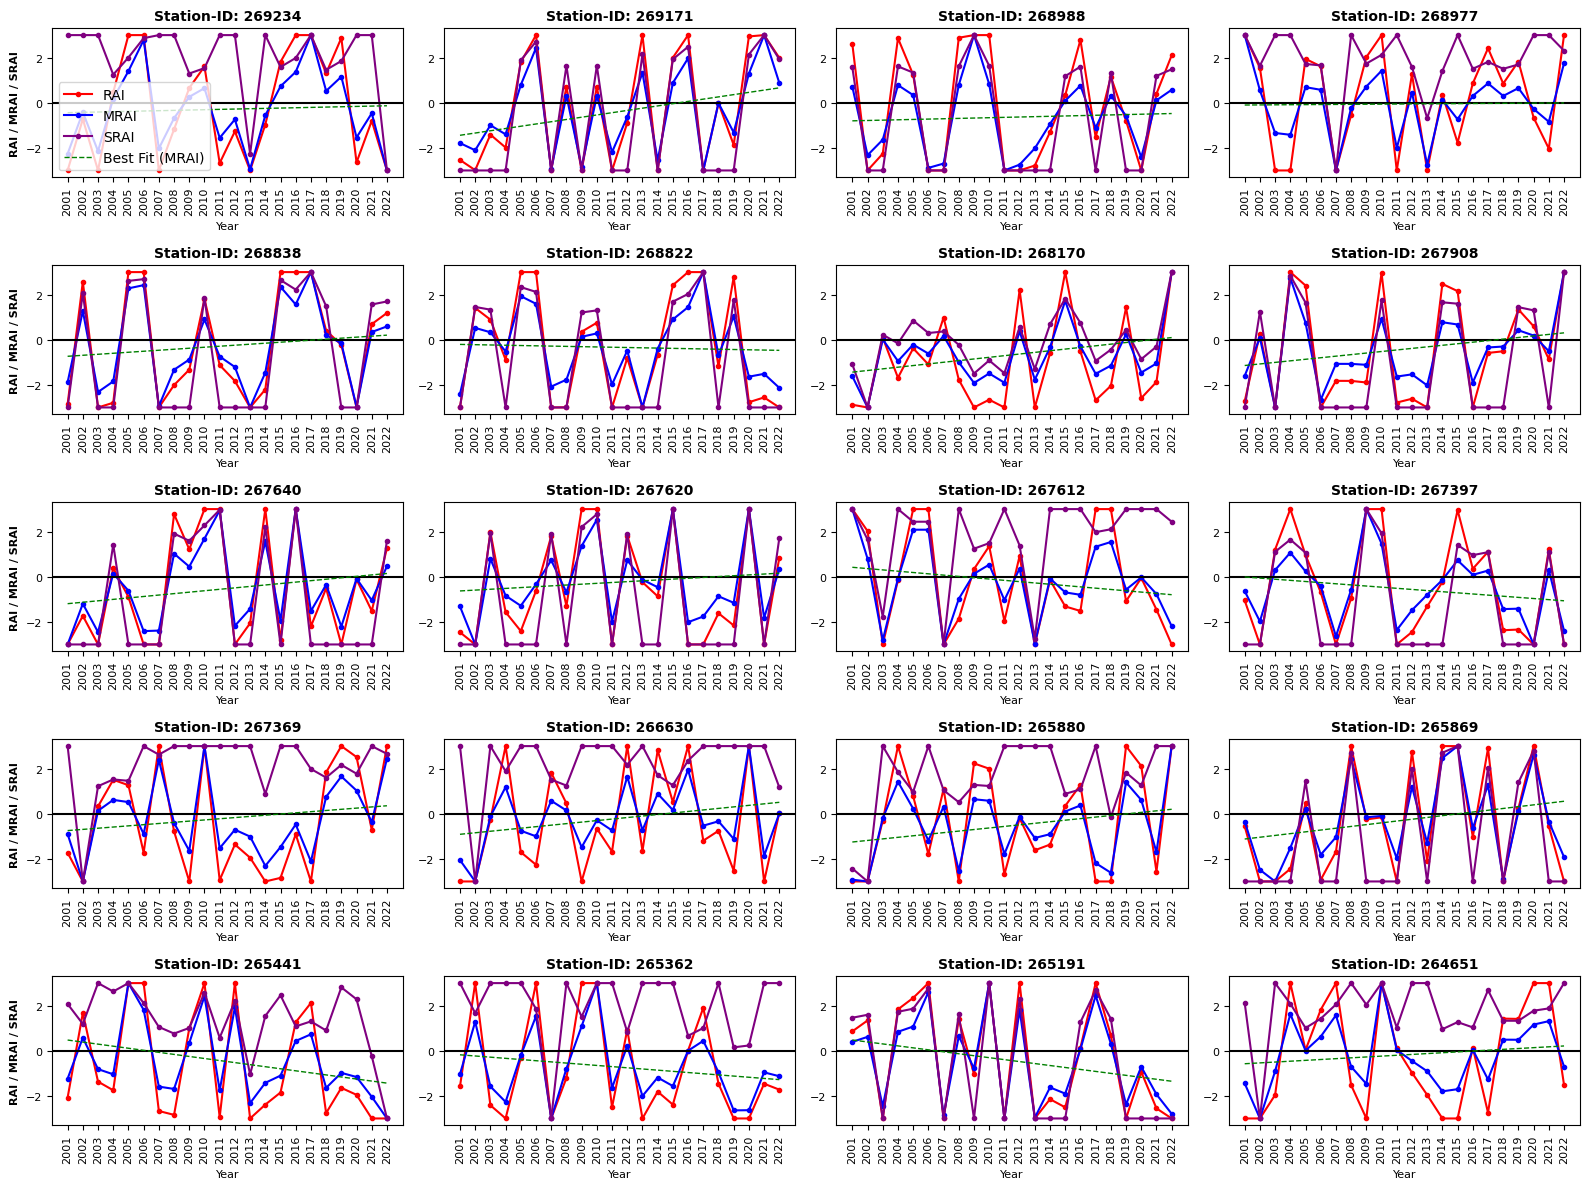

In [27]:

# Step 1: Load the data from the CSV file
file_path = os.path.join('Data', 'anomalyAllnew.csv')
data = pd.read_csv(file_path)

# Step 2: Define the list of specific IDs to be plotted
selected_ids = [269234, 269171, 268988, 268977, 268838, 268822, 268170, 267908, 267640, 267620,
                267612, 267397, 267369, 266630, 265880, 265869, 265441, 265362, 265191, 264651]

# Step 3: Filter data to include only the fields needed and the selected IDs
filtered_data = data[['ID', 'Year', 'pre24h_RAI', 'pre24h_MRAI', 'pre24h_SRAI']].loc[data['ID'].isin(selected_ids)]

# Step 4: Create subplots (5 rows and 4 columns)
fig, axs = plt.subplots(5, 4, figsize=(16, 12))  # 5x4 grid, adjust figsize to fit subplots
axs = axs.flatten()  # Flatten to easily iterate over subplots

# Step 5: Loop through each unique ID and plot the data for each ID in a separate subplot
for i, id_value in enumerate(selected_ids):
    id_data = filtered_data[filtered_data['ID'] == id_value]
    
    # Extract data for plotting
    years = id_data['Year']
    pre24h_RAI = id_data['pre24h_RAI']
    pre24h_MRAI = id_data['pre24h_MRAI']
    pre24h_SRAI = id_data['pre24h_SRAI']
    
    # Plot 'pre24h_RAI' in red and 'pre24h_MRAI' in blue
    axs[i].plot(years, pre24h_RAI, color='red', label='RAI', marker='o', markersize=3)
    axs[i].plot(years, pre24h_MRAI, color='blue', label='MRAI', marker='o', markersize=3)
    axs[i].plot(years, pre24h_SRAI, color='purple', label='SRAI', marker='o', markersize=3)

    # Add a thick black horizontal line at y=0
    axs[i].axhline(0, color='black', linewidth=1.5)

    # Calculate and plot the line of best fit for 'pre24h_MRAI'
    if not pre24h_MRAI.isnull().all():  # Check for non-null values
        slope, intercept, _, _, _ = linregress(years, pre24h_MRAI)
        best_fit_line = slope * years + intercept
        axs[i].plot(years, best_fit_line, color='green', linestyle='--', linewidth=1, label='Best Fit (MRAI)')

    # Label each subplot with the corresponding ID
    axs[i].set_title(f'Station-ID: {id_value}', fontsize=10, fontweight='bold')
    
    # Set x-axis labels (Years) and y-axis label
    axs[i].set_xlabel('Year', fontsize=8)
    axs[0].set_ylabel('RAI / MRAI / SRAI', fontsize=8, fontweight='bold')
    axs[4].set_ylabel('RAI / MRAI / SRAI', fontsize=8, fontweight='bold')
    axs[8].set_ylabel('RAI / MRAI / SRAI', fontsize=8, fontweight='bold')
    axs[12].set_ylabel('RAI / MRAI / SRAI', fontsize=8, fontweight='bold')
    axs[16].set_ylabel('RAI / MRAI / SRAI', fontsize=8, fontweight='bold')
    
    # Adjust the x-axis to display only years 2001-2022
    axs[i].set_xticks(years)
    axs[i].tick_params(axis='x', labelrotation=90, labelsize=8)
    axs[i].tick_params(axis='y', labelsize=8)
    
    # Add legend only to the first plot
    if i == 0:
        axs[i].legend(loc='lower left', fontsize=10)

    # Add grid for better readability
#     axs[i].grid(True, which='both', linestyle='--', linewidth=0.5)

# Step 6: Adjust layout to avoid overlap
plt.tight_layout()

# plt.savefig("OutputPlots/b_dry_gages")

# Step 7: Show the plot
plt.show()


In [24]:

# Step 1: Load the data from the CSV file
file_path = os.path.join('Data', 'anomalyAllnew.csv')
data = pd.read_csv(file_path)

# Step 2: Filter data for the years between 2001 and 2022
years = list(range(2001, 2023))
filtered_data = data[data['Year'].isin(years)]

# Create a directory to save results
output_dir = "Outputs"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Step 3: Define the specific IDs to be analyzed
selected_ids = [269234, 269171, 268988, 268977, 268838, 268822, 268170, 267908, 267640, 267620,
                267612, 267397, 267369, 266630, 265880, 265869, 265441, 265362, 265191, 264651]

# Step 4: Define the function to calculate the statistical metrics
def calculate_stats(obs, pred):
    # Correlation Coefficient (CC)
    cc, _ = stats.pearsonr(obs, pred)
    
    # Percentage Relative Bias (PRB)
    prb = np.sum(pred - obs) / np.sum(obs) # * 100
    
    # Root Mean Square Error (RMSE)
    rmse = np.sqrt(np.mean((pred - obs) ** 2))
    
    # Mean Bias Ratio (MBR) with flooring at 0 and capping at 1
    mbr = np.mean(pred) / np.mean(obs)
    mbr = np.clip(mbr, 0, 1)  # Ensures MBR is between 0 and 1
    
    # Nash-Sutcliffe Efficiency (NSE)
    nse = he.evaluator(he.nse, pred, obs)[0]
    
    # Kling-Gupta Efficiency (KGE)
    kge, r_cor, alpha, beta = he.evaluator(he.kge, pred, obs)
    
    return cc, prb, rmse, mbr, nse, kge[0]

# Step 5: Initialize the results list
results = []

# Step 6: Loop through each unique ID and calculate statistics for all data from 2001 to 2022
for id_value in selected_ids:
    id_data = filtered_data[filtered_data['ID'] == id_value]
    
    # Extract observed and predicted values for both MRAI and SRAI comparisons
    obs_RAI = id_data['pre24h_RAI'].values
    pred_MRAI = id_data['pre24h_MRAI'].values
    pred_SRAI = id_data['pre24h_SRAI'].values
    lat = id_data['Lat'].values[0]  # Get the first value of Lat for this ID
    lon = id_data['Lon'].values[0]  # Get the first value of Lon for this ID
    
    # Check if observed and predicted data are non-empty for calculation
    if len(obs_RAI) > 0:
        # Calculate metrics for MRAI vs RAI
        if len(pred_MRAI) > 0:
            cc_mrai, prb_mrai, rmse_mrai, mbr_mrai, nse_mrai, kge_mrai = calculate_stats(obs_RAI, pred_MRAI)
        else:
            cc_mrai = prb_mrai = rmse_mrai = mbr_mrai = nse_mrai = kge_mrai = np.nan
        
        # Calculate metrics for SRAI vs RAI
        if len(pred_SRAI) > 0:
            cc_srai, prb_srai, rmse_srai, mbr_srai, nse_srai, kge_srai = calculate_stats(obs_RAI, pred_SRAI)
        else:
            cc_srai = prb_srai = rmse_srai = mbr_srai = nse_srai = kge_srai = np.nan
        
        # Append results for each ID with calculated metrics
        results.append([id_value, lat, lon, cc_mrai, prb_mrai, rmse_mrai, mbr_mrai, nse_mrai, kge_mrai,
                        cc_srai, prb_srai, rmse_srai, mbr_srai, nse_srai, kge_srai])

# Step 7: Convert results to a DataFrame and save it as a CSV file
results_df = pd.DataFrame(results, columns=[
    'ID', 'Lat', 'Lon', 
    'CC_MRAI', 'PRB_MRAI', 'RMSE_MRAI', 'MBR_MRAI', 'NSE_MRAI', 'KGE_MRAI', 
    'CC_SRAI', 'PRB_SRAI', 'RMSE_SRAI', 'MBR_SRAI', 'NSE_SRAI', 'KGE_SRAI'
])

output_file_path = os.path.join(output_dir, 'metric_Dry_gages.csv')
results_df.to_csv(output_file_path, index=False)

print("Statistical metrics saved to:", output_file_path)

Statistical metrics saved to: Outputs\metric_Dry_gages.csv


### **All Stations**

In [25]:

# Step 1: Load the data from the CSV file
file_path = os.path.join('Data', 'anomalyAllnew.csv')
data = pd.read_csv(file_path)

# Step 2: Filter data for the years between 2001 and 2022
years = list(range(2001, 2023))
filtered_data = data[data['Year'].isin(years)]

# Create a directory to save results
output_dir = "Outputs"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


# Step 3: Define the function to calculate the statistical metrics
def calculate_stats(obs, pred):
    # Correlation Coefficient (CC)
    cc, _ = stats.pearsonr(obs, pred)
    
    # Percentage Relative Bias (PRB)
    prb = np.sum(pred - obs) / np.sum(obs) # * 100
    
    # Root Mean Square Error (RMSE)
    rmse = np.sqrt(np.mean((pred - obs) ** 2))
    
    # Mean Bias Ratio (MBR) with flooring at 0 and capping at 1
    mbr = np.mean(pred) / np.mean(obs)
    mbr = np.clip(mbr, 0, 1)  # Ensures MBR is between 0 and 1
    
    # Nash-Sutcliffe Efficiency (NSE)
    nse = he.evaluator(he.nse, pred, obs)[0]
    
    # Kling-Gupta Efficiency (KGE)
    kge, r_cor, alpha, beta = he.evaluator(he.kge, pred, obs)
    
    return cc, prb, rmse, mbr, nse, kge[0]

# Step 4: Get unique IDs
unique_ids = filtered_data['ID'].unique()

# Step 5: Initialize the results list
results = []

# Step 6: Loop through each unique ID and calculate statistics for all data from 2001 to 2022
for id_value in unique_ids:
    id_data = filtered_data[filtered_data['ID'] == id_value]
    
    # Extract observed and predicted values for both MRAI and SRAI comparisons
    obs_RAI = id_data['pre24h_RAI'].values
    pred_MRAI = id_data['pre24h_MRAI'].values
    pred_SRAI = id_data['pre24h_SRAI'].values
    lat = id_data['Lat'].values[0]  # Get the first value of Lat for this ID
    lon = id_data['Lon'].values[0]  # Get the first value of Lon for this ID
    
    # Check if observed and predicted data are non-empty for calculation
    if len(obs_RAI) > 0:
        # Calculate metrics for MRAI vs RAI
        if len(pred_MRAI) > 0:
            cc_mrai, prb_mrai, rmse_mrai, mbr_mrai, nse_mrai, kge_mrai = calculate_stats(obs_RAI, pred_MRAI)
        else:
            cc_mrai = prb_mrai = rmse_mrai = mbr_mrai = nse_mrai = kge_mrai = np.nan
        
        # Calculate metrics for SRAI vs RAI
        if len(pred_SRAI) > 0:
            cc_srai, prb_srai, rmse_srai, mbr_srai, nse_srai, kge_srai = calculate_stats(obs_RAI, pred_SRAI)
        else:
            cc_srai = prb_srai = rmse_srai = mbr_srai = nse_srai = kge_srai = np.nan
        
        # Append results for each ID with calculated metrics
        results.append([id_value, lat, lon, cc_mrai, prb_mrai, rmse_mrai, mbr_mrai, nse_mrai, kge_mrai,
                        cc_srai, prb_srai, rmse_srai, mbr_srai, nse_srai, kge_srai])

# Step 7: Convert results to a DataFrame and save it as a CSV file
results_df = pd.DataFrame(results, columns=[
    'ID', 'Lat', 'Lon', 
    'CC_MRAI', 'PRB_MRAI', 'RMSE_MRAI', 'MBR_MRAI', 'NSE_MRAI', 'KGE_MRAI', 
    'CC_SRAI', 'PRB_SRAI', 'RMSE_SRAI', 'MBR_SRAI', 'NSE_SRAI', 'KGE_SRAI'
])

output_file_path = os.path.join(output_dir, 'metric_All_gages.csv')
results_df.to_csv(output_file_path, index=False)

print("Statistical metrics saved to:", output_file_path)

Statistical metrics saved to: Outputs\metric_All_gages.csv


### **Assessment BY Year (MRAI vs RAI)**

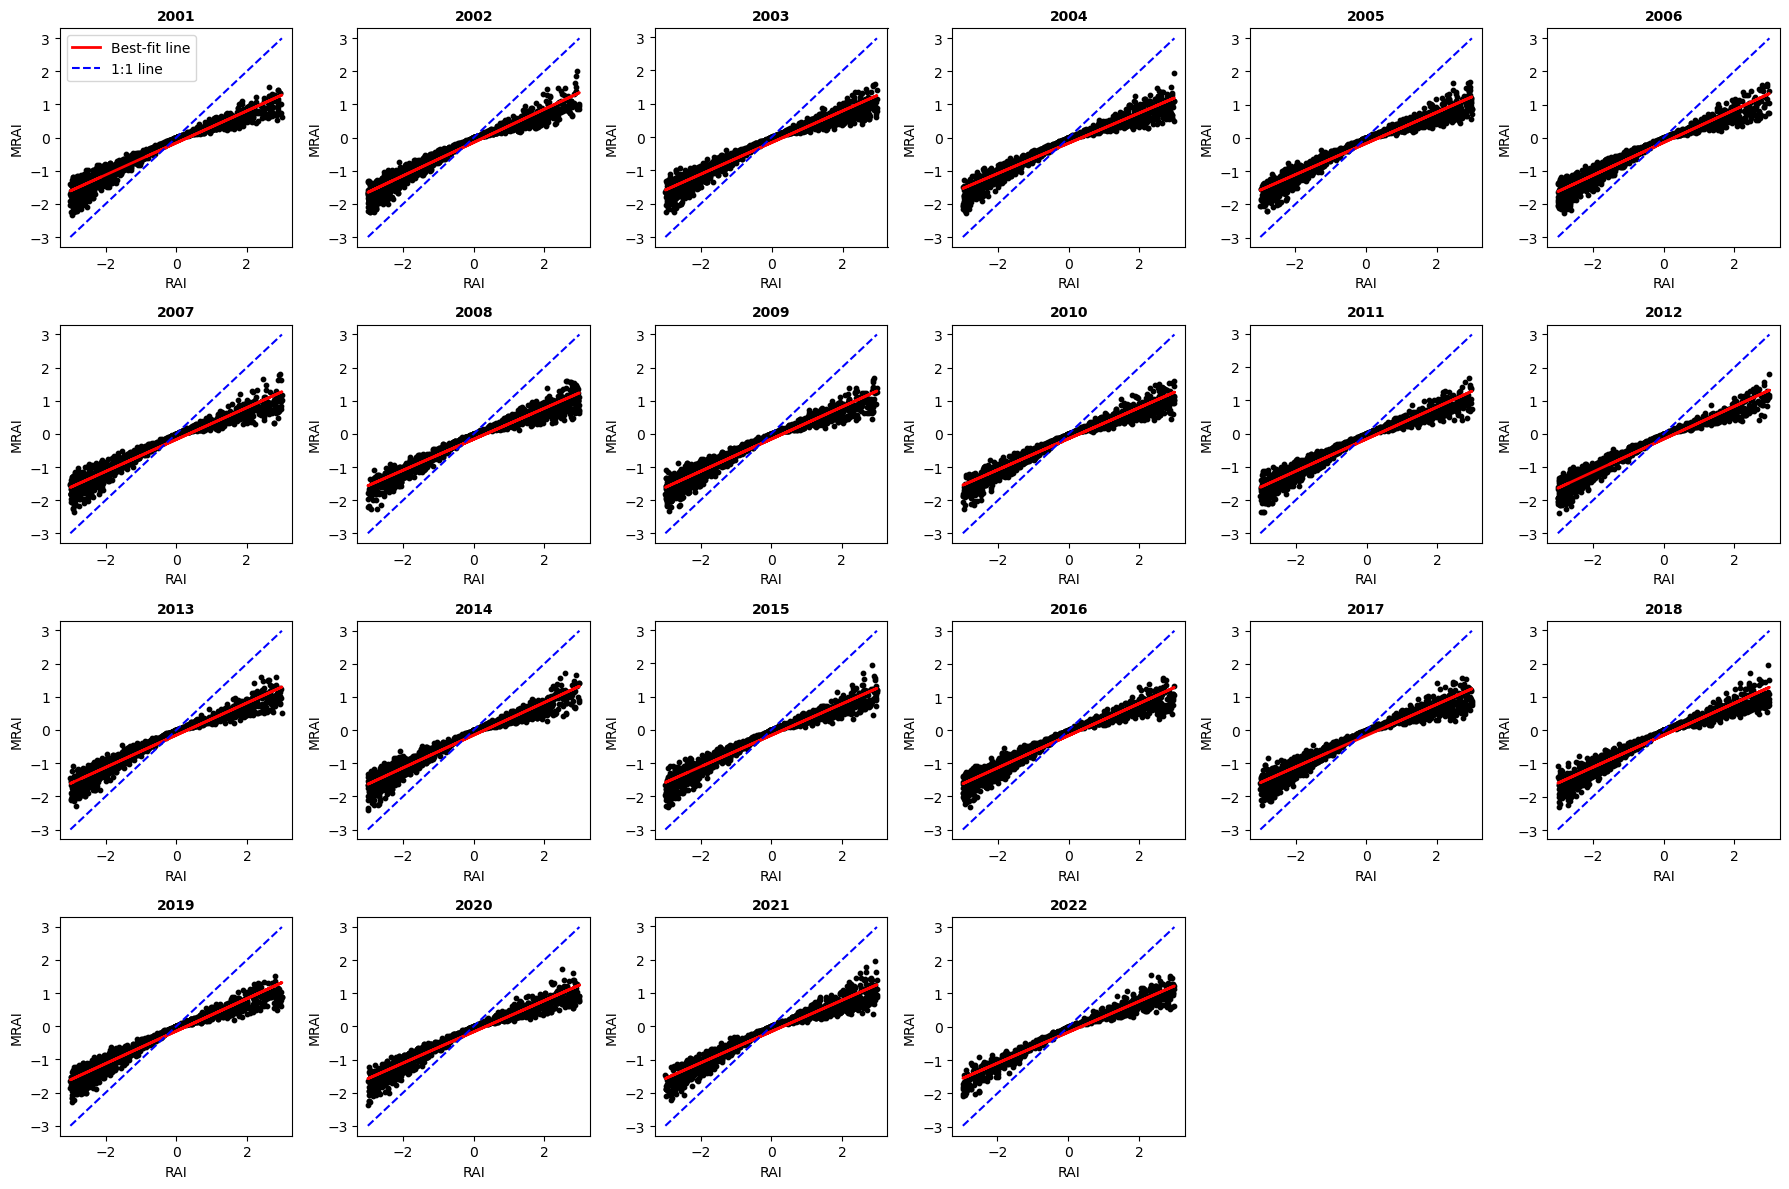

In [28]:

# Step 1: Load the data from the CSV file
file_path = os.path.join('Data', 'anomalyAllnew.csv')
data = pd.read_csv(file_path)

# Step 2: Filter data for the years between 2001 and 2022
years = list(range(2001, 2023))
filtered_data = data[data['Year'].isin(years)]

# Step 3: Create subplots for each year
num_years = len(years)
fig, axs = plt.subplots(4, 6, figsize=(18, 12))  # Adjust subplot grid and figure size to accommodate all years
axs = axs.flatten()

# Step 4: Plot the scatter plots for each year and add best-fit and one-to-one lines
for i, year in enumerate(years):
    year_data = filtered_data[filtered_data['Year'] == year]
    
    # Filter out values where pre24h_RAI or pre24h_MRAI is exactly +3 or -3
    year_data = year_data[(year_data['pre24h_RAI'] != 3) & (year_data['pre24h_RAI'] != -3)]
    year_data = year_data[(year_data['pre24h_MRAI'] != 3) & (year_data['pre24h_MRAI'] != -3)]
    
    # Scatter plot of pre24h_MRAI vs pre24h_RAI
    axs[i].scatter(year_data['pre24h_RAI'], year_data['pre24h_MRAI'], color='black', marker='o', s=10) 
    
    # Best-fit line (red)
    if not year_data.empty:
        m, b = np.polyfit(year_data['pre24h_RAI'], year_data['pre24h_MRAI'], 1)  # Linear fit
        axs[i].plot(year_data['pre24h_RAI'], m * year_data['pre24h_RAI'] + b, color='red', linewidth=2, label='Best-fit line')

    # One-to-one line (blue) from min to max of the x-axis values
    min_val = min(year_data['pre24h_RAI'].min(), year_data['pre24h_MRAI'].min())
    max_val = max(year_data['pre24h_RAI'].max(), year_data['pre24h_MRAI'].max())
    axs[i].plot([min_val, max_val], [min_val, max_val], color='blue', linestyle='--', linewidth=1.5, label='1:1 line')
    
    # Label axes and title
    axs[i].set_xlabel('RAI')
    axs[i].set_ylabel('MRAI')
    axs[i].set_title(f'{year}', fontweight='bold', fontsize=10)
    
    # Add legend only to the first plot
    if i == 0:
        axs[i].legend()

# Remove any unused subplots
for j in range(num_years, len(axs)):
    fig.delaxes(axs[j])
    
# Adjust layout to avoid overlap
plt.tight_layout()
# plt.savefig("OutputPlots/c_mrai_vs_rai")
plt.show()


### **Assessment BY Year (SRAI vs RAI)**

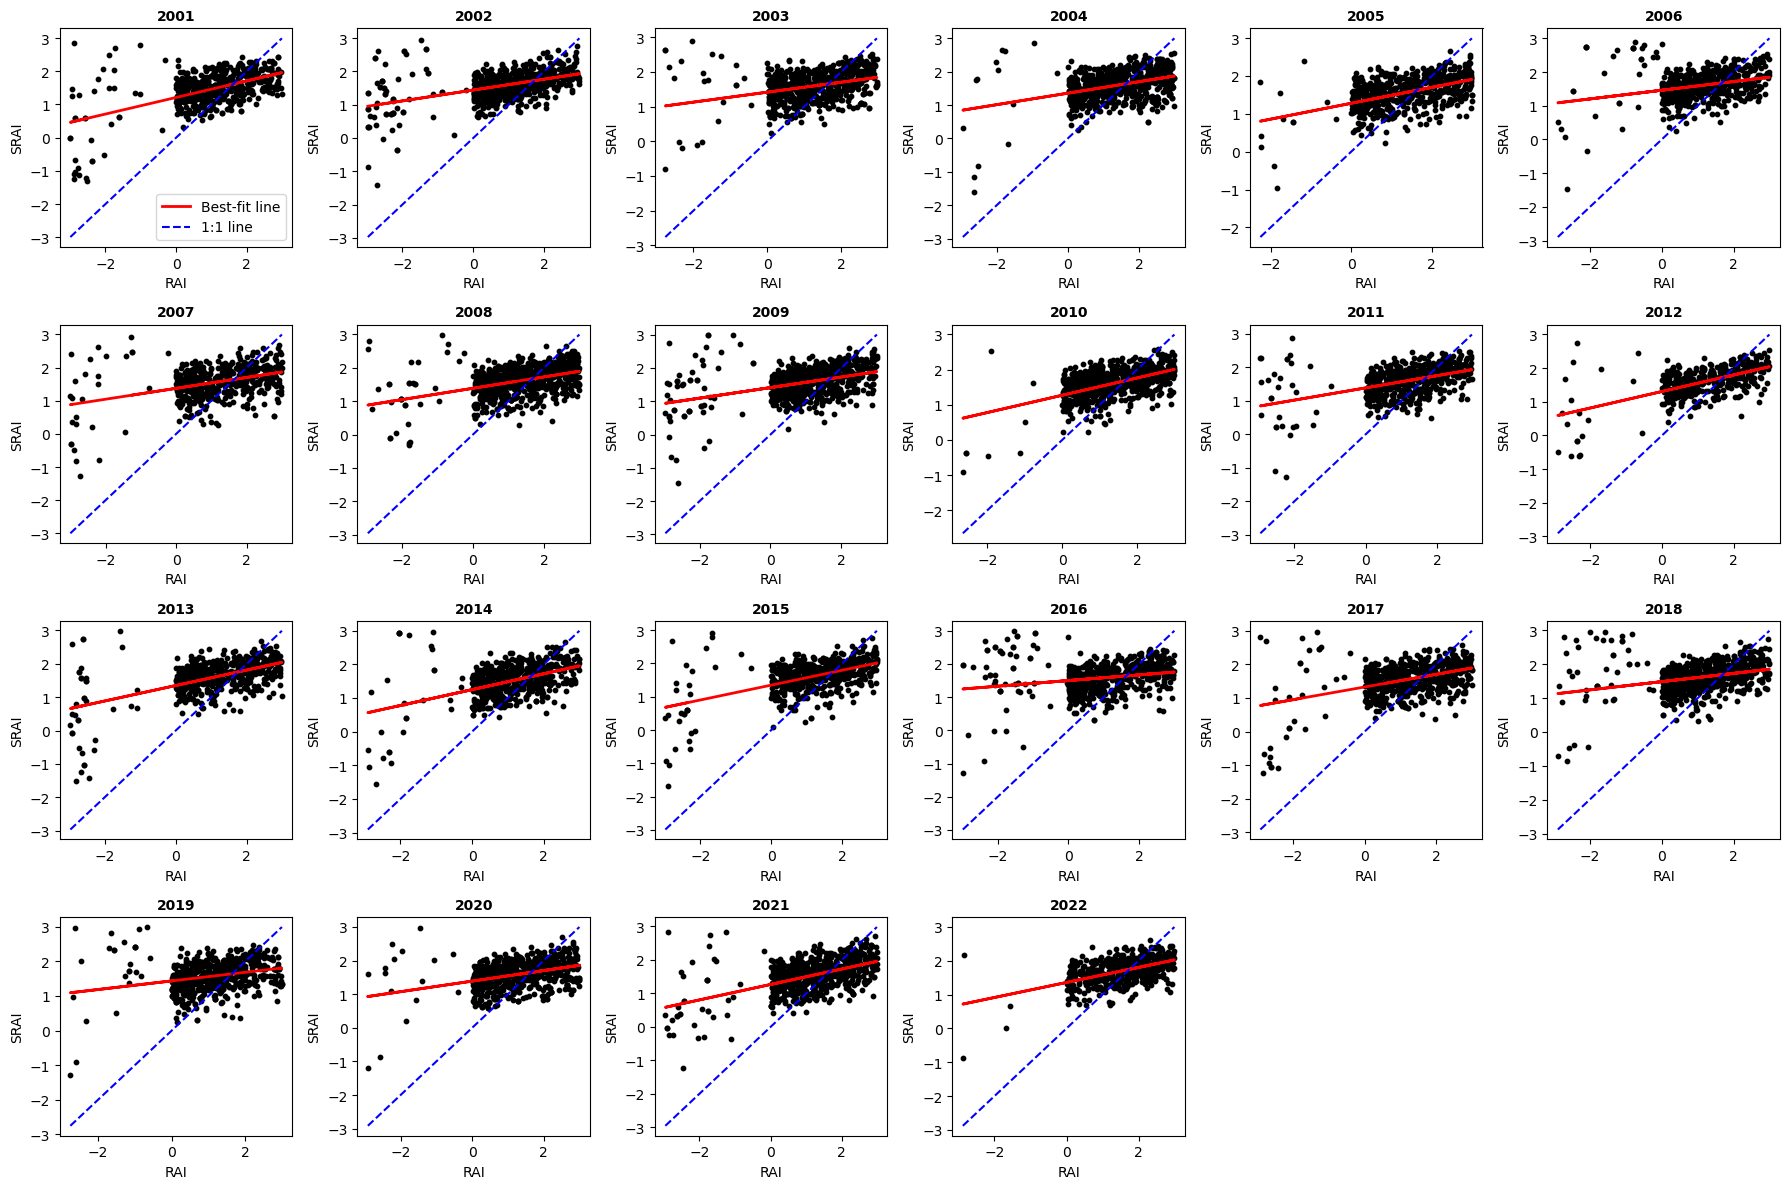

In [30]:

# Step 1: Load the data from the CSV file
file_path = os.path.join('Data', 'anomalyAllnew.csv')
data = pd.read_csv(file_path)

# Step 2: Filter data for the years between 2001 and 2022
years = list(range(2001, 2023))
filtered_data = data[data['Year'].isin(years)]

# Step 3: Create subplots for each year
num_years = len(years)
fig, axs = plt.subplots(4, 6, figsize=(18, 12))  # Adjust subplot grid and figure size to accommodate all years
axs = axs.flatten()

# Step 4: Plot the scatter plots for each year and add best-fit and one-to-one lines
for i, year in enumerate(years):
    year_data = filtered_data[filtered_data['Year'] == year]
    
    # Filter out values where pre24h_RAI or pre24h_MRAI is exactly +3 or -3
    year_data = year_data[(year_data['pre24h_RAI'] != 3) & (year_data['pre24h_RAI'] != -3)]
    year_data = year_data[(year_data['pre24h_SRAI'] != 3) & (year_data['pre24h_SRAI'] != -3)]
    
    # Scatter plot of pre24h_MRAI vs pre24h_RAI
    axs[i].scatter(year_data['pre24h_RAI'], year_data['pre24h_SRAI'], color='black', marker='o', s=10) 
    
    # Best-fit line (red)
    if not year_data.empty:
        m, b = np.polyfit(year_data['pre24h_RAI'], year_data['pre24h_SRAI'], 1)  # Linear fit
        axs[i].plot(year_data['pre24h_RAI'], m * year_data['pre24h_RAI'] + b, color='red', linewidth=2, label='Best-fit line')

    # One-to-one line (blue) from min to max of the x-axis values
    min_val = min(year_data['pre24h_RAI'].min(), year_data['pre24h_SRAI'].min())
    max_val = max(year_data['pre24h_RAI'].max(), year_data['pre24h_SRAI'].max())
    axs[i].plot([min_val, max_val], [min_val, max_val], color='blue', linestyle='--', linewidth=1.5, label='1:1 line')
    
    # Label axes and title
    axs[i].set_xlabel('RAI')
    axs[i].set_ylabel('SRAI')
    axs[i].set_title(f'{year}', fontweight='bold', fontsize=10)
    
    # Add legend only to the first plot
    if i == 0:
        axs[i].legend()

# Remove any unused subplots
for j in range(num_years, len(axs)):
    fig.delaxes(axs[j])
    
# Adjust layout to avoid overlap
plt.tight_layout()
# plt.savefig("OutputPlots/d_srai_vs_rai")
plt.show()

In [47]:

# Step 1: Load the data from the CSV file
file_path = os.path.join('Data', 'anomalyAllnew.csv')
data = pd.read_csv(file_path)

# Step 2: Filter data for the years between 2001 and 2022
years = list(range(2001, 2023))
filtered_data = data[data['Year'].isin(years)]

# Create a directory to save results
output_dir = "Outputs"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Step 3: Define the function to calculate the statistical metrics
def calculate_stats(obs, pred):
    # Correlation Coefficient (CC)
    cc, _ = stats.pearsonr(obs, pred)
    
    # Percentage Relative Bias (PRB)
    prb = np.sum(pred - obs) / np.sum(obs) * 100
    
    # Root Mean Square Error (RMSE)
    rmse = np.sqrt(np.mean((pred - obs) ** 2))
    
    # Mean Bias Ratio (MBR) with flooring at 0 and capping at 1
    mbr = np.mean(pred) / np.mean(obs)
    mbr = np.clip(mbr, 0, 1)  # Ensures MBR is between 0 and 1
    
    # Nash-Sutcliffe Efficiency (NSE)
    nse = he.evaluator(he.nse, pred, obs)[0]
    
    # Kling-Gupta Efficiency (KGE)
    kge, r_cor, alpha, beta = he.evaluator(he.kge, pred, obs)
    
    return cc, prb, rmse, mbr, nse, kge[0]

# Step 4: Initialize the results list
results = []

# Step 5: Calculate statistics for each year for both "pre24h_MRAI" and "pre24h_SRAI"
for year in years:
    year_data = filtered_data[filtered_data['Year'] == year]
    
    # Calculate metrics for "pre24h_MRAI" vs "pre24h_RAI"
    obs_MRAI = year_data['pre24h_RAI'].values
    pred_MRAI = year_data['pre24h_MRAI'].values
    if len(obs_MRAI) > 0 and len(pred_MRAI) > 0:
        cc_MRAI, prb_MRAI, rmse_MRAI, mbr_MRAI, nse_MRAI, kge_MRAI = calculate_stats(obs_MRAI, pred_MRAI)
    else:
        cc_MRAI, prb_MRAI, rmse_MRAI, mbr_MRAI, nse_MRAI, kge_MRAI = [np.nan] * 6
    
    # Calculate metrics for "pre24h_SRAI" vs "pre24h_RAI"
    obs_SRAI = year_data['pre24h_RAI'].values
    pred_SRAI = year_data['pre24h_SRAI'].values
    if len(obs_SRAI) > 0 and len(pred_SRAI) > 0:
        cc_SRAI, prb_SRAI, rmse_SRAI, mbr_SRAI, nse_SRAI, kge_SRAI = calculate_stats(obs_SRAI, pred_SRAI)
    else:
        cc_SRAI, prb_SRAI, rmse_SRAI, mbr_SRAI, nse_SRAI, kge_SRAI = [np.nan] * 6
    
    # Append the result for each year
    results.append([year, cc_MRAI, prb_MRAI, rmse_MRAI, mbr_MRAI, nse_MRAI, kge_MRAI,
                    cc_SRAI, prb_SRAI, rmse_SRAI, mbr_SRAI, nse_SRAI, kge_SRAI])

# Step 6: Convert results to a DataFrame and save it as a CSV file
results_df = pd.DataFrame(results, columns=['Year', 'CC_MRAI', 'PRB_MRAI', 'RMSE_MRAI', 
                                            'MBR_MRAI', 'NSE_MRAI', 'KGE_MRAI', 
                                            'CC_SRAI', 'PRB_SRAI', 'RMSE_SRAI', 
                                            'MBR_SRAI', 'NSE_SRAI', 'KGE_SRAI'])

output_file_path = os.path.join(output_dir, 'metricByYear.csv')
results_df.to_csv(output_file_path, index=False)

print("Statistical results saved to:", output_file_path)


Statistical results saved to: Outputs\metricByYear.csv


### **Boxplot BY Year**

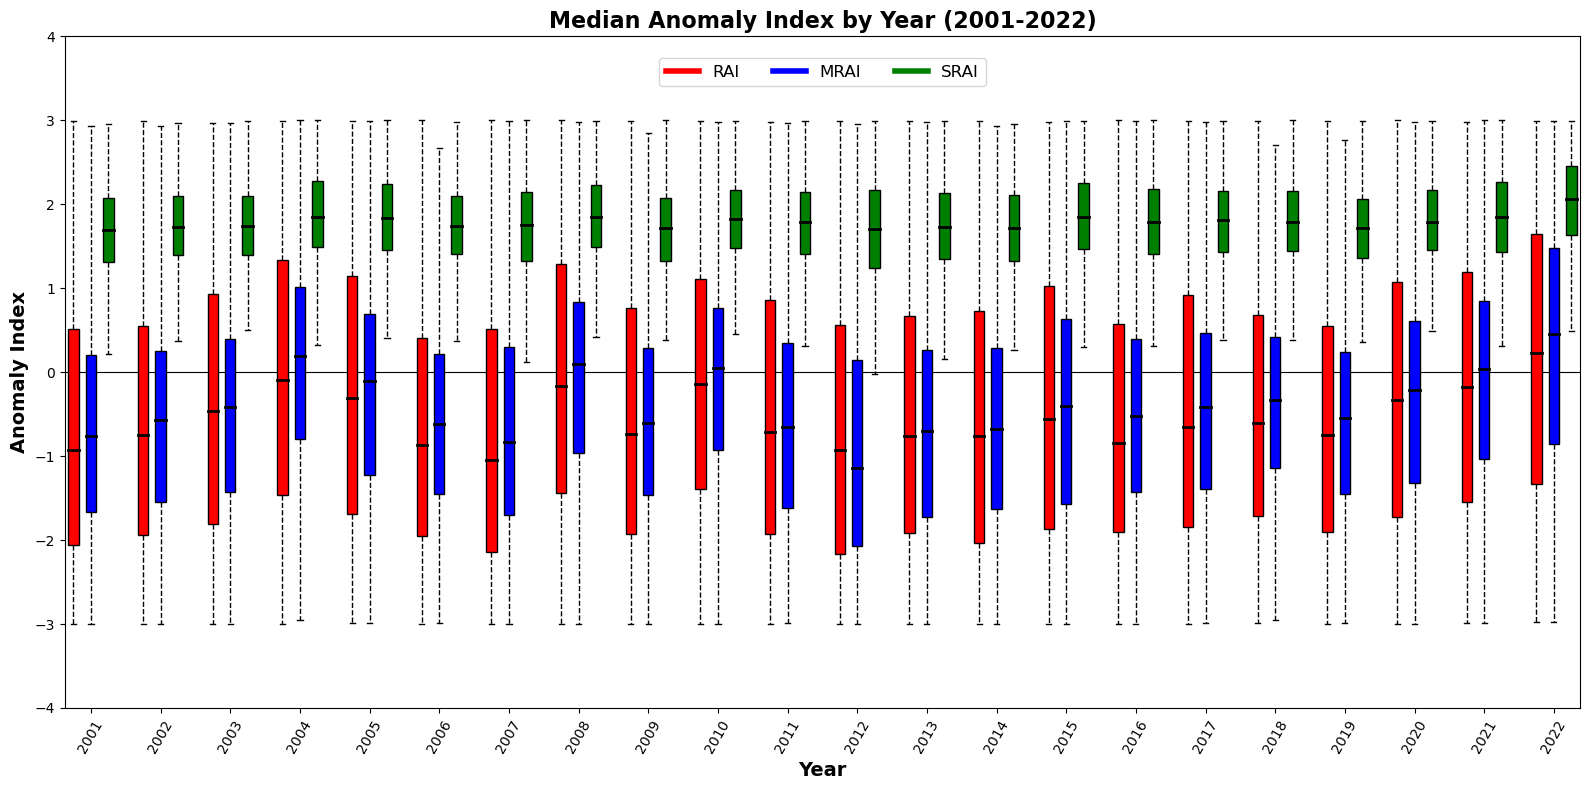

In [83]:

# Step 1: Load the data from the CSV file
file_path = os.path.join('Data', 'anomalyAllnew.csv')
data = pd.read_csv(file_path)

# Step 2: Filter data for the years between 2001 and 2022
years = list(range(2001, 2023))
filtered_data = data[data['Year'].isin(years)]

# Step 3: Prepare data for boxplots
boxplot_data = []
positions = []
boxplot_labels = []

# Spacing between groups
spacing = 4

# Loop through each year and add data for RAI, MRAI, SRAI
for i, year in enumerate(years):
    year_data = filtered_data[filtered_data['Year'] == year]
    
    # Filter out values where (pre24h_RAI, pre24h_MRAI, pre24h_SRAI) is exactly +3 or -3
    pre24h_RAI = year_data[(year_data['pre24h_RAI'] != 3) & (year_data['pre24h_RAI'] != -3)]['pre24h_RAI'].values
    pre24h_MRAI = year_data[(year_data['pre24h_MRAI'] != 3) & (year_data['pre24h_MRAI'] != -3)]['pre24h_MRAI'].values
    pre24h_SRAI = year_data[(year_data['pre24h_SRAI'] != 3) & (year_data['pre24h_SRAI'] != -3)]['pre24h_SRAI'].values
    
    # Append data for boxplots
    boxplot_data.extend([pre24h_RAI, pre24h_MRAI, pre24h_SRAI])
    
    # Define positions with spacing for each year’s RAI, MRAI, SRAI
    base_position = i * spacing
    positions.extend([base_position, base_position + 1, base_position + 2])
    
    # Add label for the center of each year’s group
    boxplot_labels.append(year)

# Create a boxplot with adjusted positions
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the boxplot
bp = ax.boxplot(boxplot_data, showfliers=False, patch_artist=True, positions=positions, widths=0.6,
                boxprops=dict(color='black'), 
                whiskerprops=dict(color='black', linestyle='--'),  # Broken line for whiskers
                medianprops=dict(color='black', linewidth=2))

# Set custom colors for each metric: RAI (red), MRAI (blue), SRAI (green)
colors = ['red', 'blue', 'green'] * len(years)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Set plot title and labels
ax.set_title('Median Anomaly Index by Year (2001-2022)', fontweight='bold', fontsize=16)
ax.set_xlabel('Year', fontsize=14, fontweight='bold')
ax.set_ylabel('Anomaly Index', fontsize=14, fontweight='bold')

# Add a horizontal legend for RAI, MRAI, and SRAI
custom_lines = [
    plt.Line2D([0], [0], color='red', lw=4),
    plt.Line2D([0], [0], color='blue', lw=4),
    plt.Line2D([0], [0], color='green', lw=4)
]
ax.legend(custom_lines, ['RAI', 'MRAI', 'SRAI'], loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=3, fontsize=12)

# Set y-axis limit
ax.set_ylim([-4, 4])

# Set x-axis labels to center under each year group
ax.set_xticks([i * spacing + 1 for i in range(len(years))])
ax.set_xticklabels(boxplot_labels, rotation=60)

# Add a solid black line at y=0
ax.axhline(0, color='black', linestyle='-', linewidth=0.8)

# Adjust layout to fit labels
plt.tight_layout()

# Save or display the plot
plt.savefig("OutputPlots/e_boxplotByYear.png")
plt.show()


### **Density Distribution Plot**

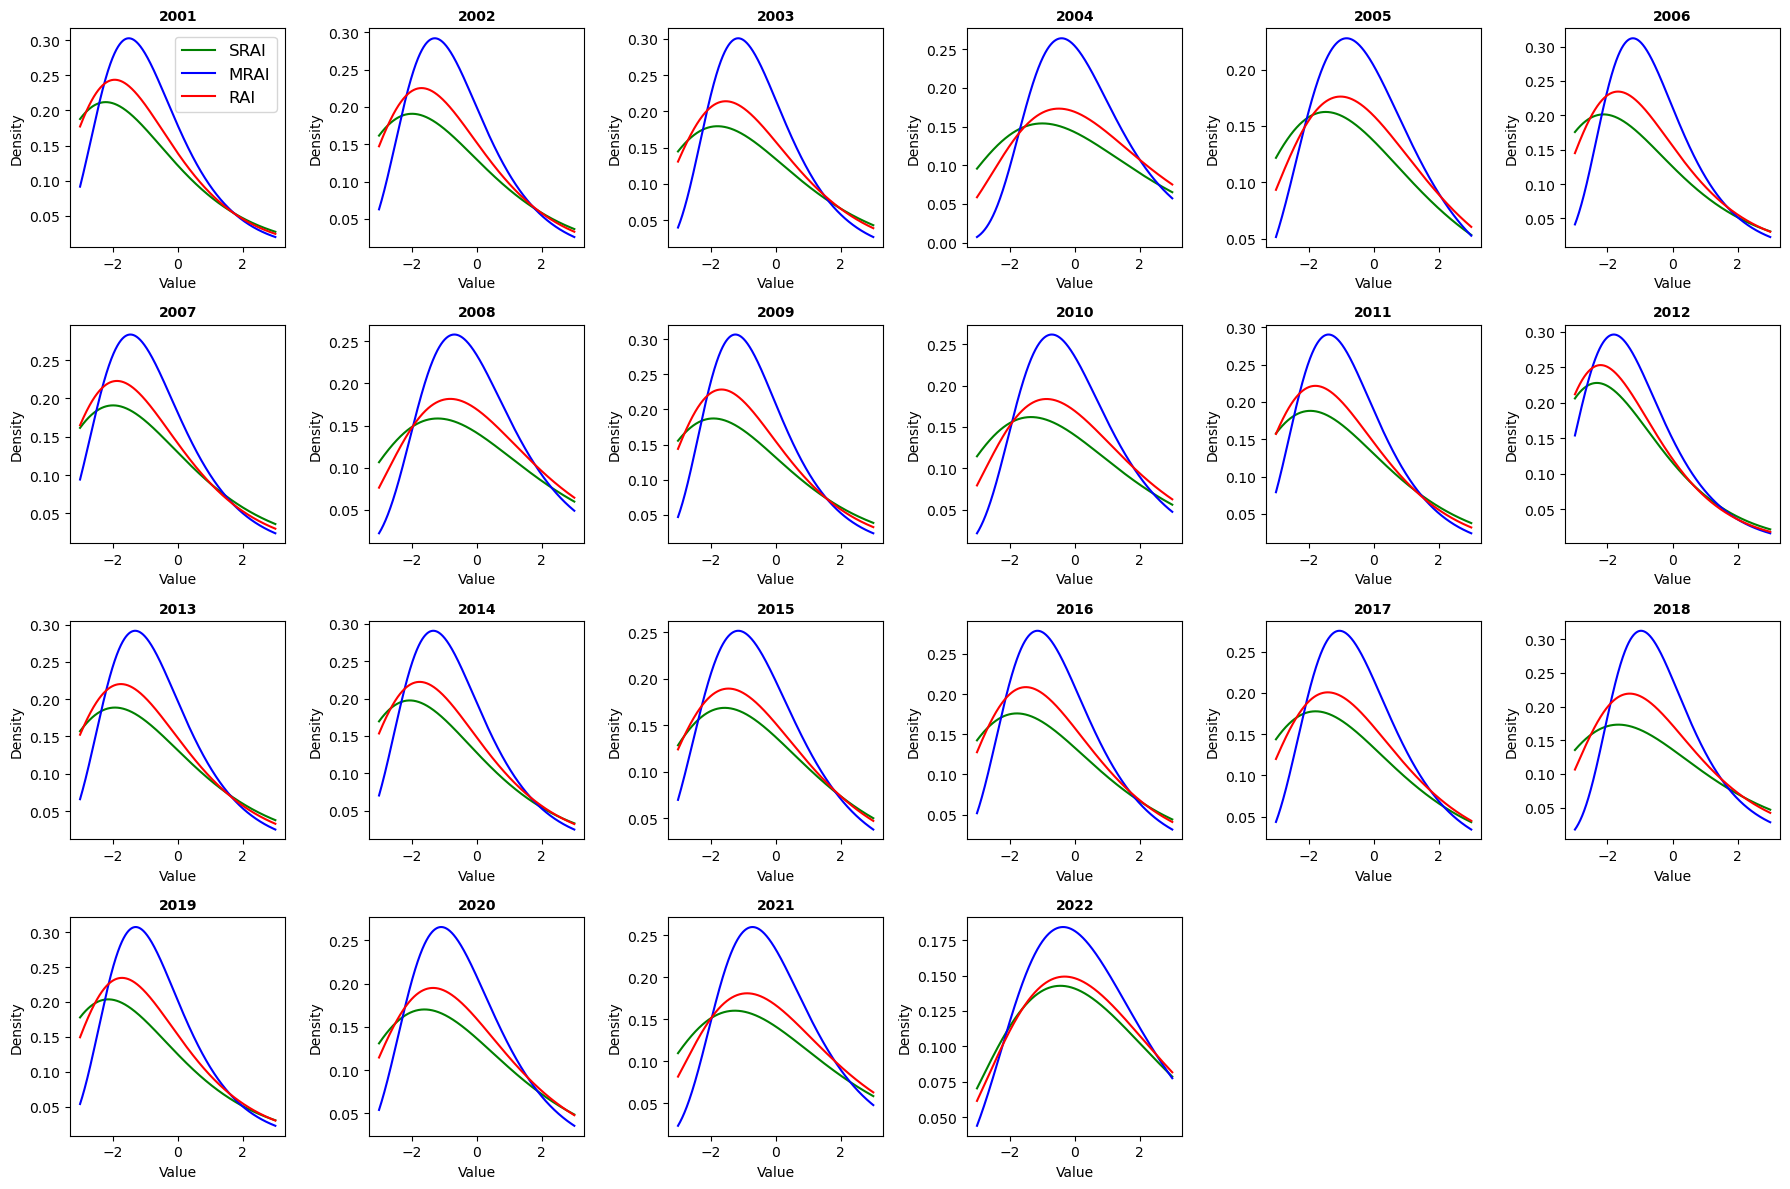

In [59]:

# Step 1: Load the data from the CSV file
file_path = os.path.join('Data', 'anomalyAllnew.csv')
data = pd.read_csv(file_path)

# Step 2: Filter data for the years between 2001 and 2022
years = list(range(2001, 2023))
filtered_data = data[data['Year'].isin(years)]

# Define the number of rows and columns for subplots
num_years = len(years)
fig, axs = plt.subplots(4, 6, figsize=(18, 12))
axs = axs.flatten()

# Function to fit and plot Gumbel distribution
def plot_gumbel_distribution(ax, data, color, label, show_legend=False):
    # Fit Gumbel distribution
    params = gumbel_r.fit(data)
    
    # Generate x values for the PDF
    x = np.linspace(np.min(data), np.max(data), 1000)
    
    # Generate the PDF values
    pdf = gumbel_r.pdf(x, *params)
    
    # Plot the Gumbel distribution
    ax.plot(x, pdf, color=color, label=label)
    
    # Set titles and labels
    ax.set_title(f'{year}', fontweight='bold', fontsize=10)
    ax.set_xlabel('Value', fontweight='light', fontsize=10)
    ax.set_ylabel('Density', fontweight='light', fontsize=10)
    
    # Set legend only if show_legend is True
    if show_legend:
        ax.legend(loc='upper right', fontsize=12)

# Step 3: Plot the Gumbel distribution for each year
for i, year in enumerate(years):
    year_data = filtered_data[filtered_data['Year'] == year]
    
    pre24h_RAI = year_data['pre24h_RAI'].dropna().values    # pre24h_RAI
    pre24h_MRAI = year_data['pre24h_MRAI'].dropna().values  # pre24h_MRAI
    pre24h_SRAI = year_data['pre24h_SRAI'].dropna().values  # pre24h_SRAI
    
    ax = axs[i]
    
    # Set the legend to be shown only for the first subplot
    show_legend = (i == 0)
    
    # Plot Gumbel distribution for pre24h_SRAI in blue
    plot_gumbel_distribution(ax, pre24h_SRAI, 'green', 'SRAI', show_legend)
    
    # Plot Gumbel distribution for pre24h_MRAI in blue
    plot_gumbel_distribution(ax, pre24h_MRAI, 'blue', 'MRAI', show_legend)
    
    # Plot Gumbel distribution for pre24h_RAI in red
    plot_gumbel_distribution(ax, pre24h_RAI, 'red', 'RAI', show_legend)

# Remove any unused subplots
for j in range(num_years, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout to avoid overlap
plt.tight_layout()

# plt.savefig("OutputPlots/f_DistByYear")
plt.show()


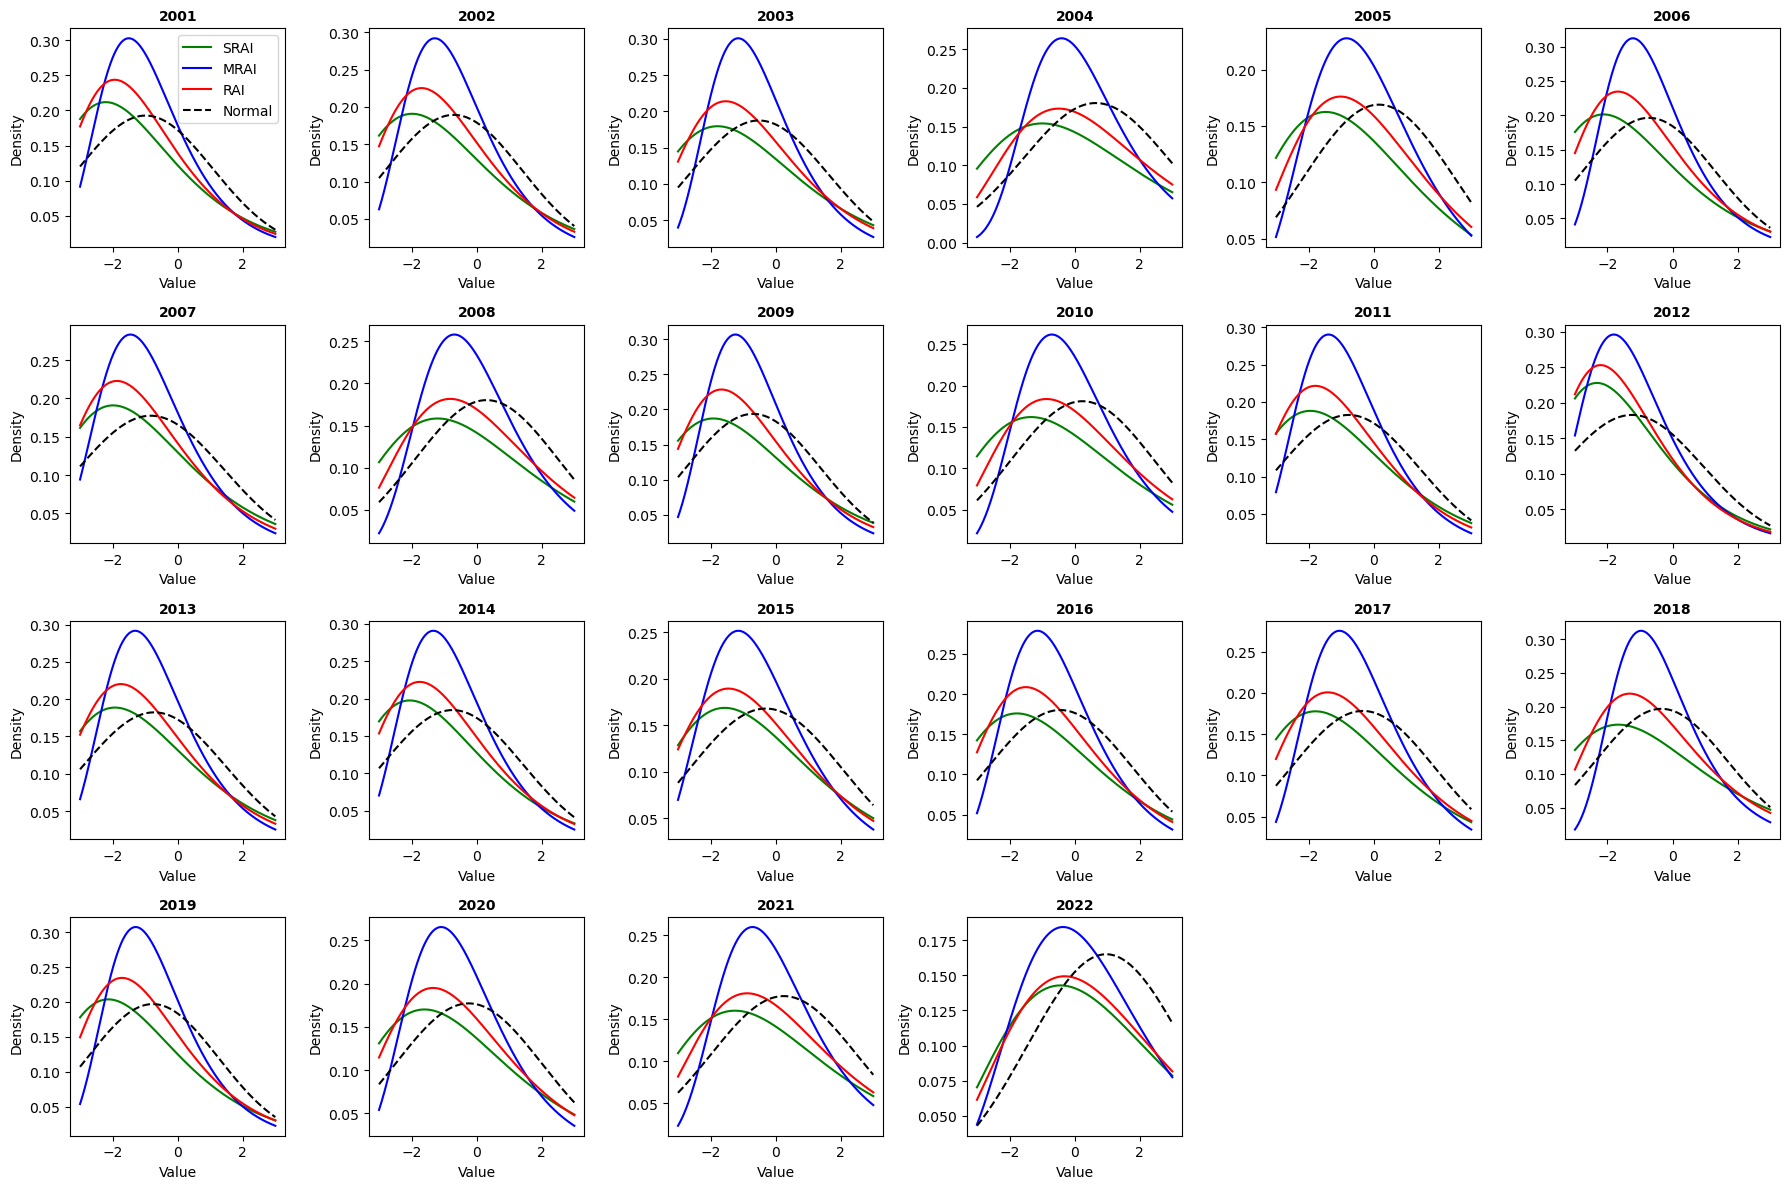

In [60]:

# Step 1: Load the data from the CSV file
file_path = os.path.join('Data', 'anomalyAllnew.csv')
data = pd.read_csv(file_path)

# Step 2: Filter data for the years between 2001 and 2022
years = list(range(2001, 2023))
filtered_data = data[data['Year'].isin(years)]

# Define the number of rows and columns for subplots
num_years = len(years)
fig, axs = plt.subplots(4, 6, figsize=(18, 12))
axs = axs.flatten()

# Function to fit and plot Gumbel distribution
def plot_gumbel_distribution(ax, data, color, label, show_legend=False):
    # Fit Gumbel distribution
    params = gumbel_r.fit(data)
    
    # Generate x values for the PDF
    x = np.linspace(np.min(data), np.max(data), 1000)
    
    # Generate the PDF values
    pdf = gumbel_r.pdf(x, *params)
    
    # Plot the Gumbel distribution
    ax.plot(x, pdf, color=color, label=label, linewidth=1.5)
    
    # Show legend only if specified
    if show_legend:
        ax.legend(loc='upper right', fontsize=10)

# Function to plot an ideal normal distribution in black
def plot_normal_distribution(ax, data, show_legend=False):
    # Calculate mean and standard deviation
    mean, std = np.mean(data), np.std(data)
    
    # Generate x values and PDF for normal distribution
    x = np.linspace(np.min(data), np.max(data), 1000)
    pdf = norm.pdf(x, mean, std)
    
    # Plot the ideal normal distribution
    ax.plot(x, pdf, color='black', linestyle='--', linewidth=1.5, label='Normal')
    
    # Show legend for the first subplot only
    if show_legend:
        ax.legend(loc='upper right', fontsize=10)

# Step 3: Plot distributions for each year
for i, year in enumerate(years):
    year_data = filtered_data[filtered_data['Year'] == year]
    
    pre24h_RAI = year_data['pre24h_RAI'].dropna().values    # pre24h_RAI
    pre24h_MRAI = year_data['pre24h_MRAI'].dropna().values  # pre24h_MRAI
    pre24h_SRAI = year_data['pre24h_SRAI'].dropna().values  # pre24h_SRAI
    
    ax = axs[i]
    show_legend = (i == 0)  # Show legend only for the first plot
    
    # Plot Gumbel distributions and normal distribution
    plot_gumbel_distribution(ax, pre24h_SRAI, 'green', 'SRAI', show_legend)
    plot_gumbel_distribution(ax, pre24h_MRAI, 'blue', 'MRAI', show_legend)
    plot_gumbel_distribution(ax, pre24h_RAI, 'red', 'RAI', show_legend)
    if len(pre24h_RAI) > 0:
        plot_normal_distribution(ax, pre24h_RAI, show_legend)

    # Set titles and labels
    ax.set_title(f'{year}', fontweight='bold', fontsize=10)
    ax.set_xlabel('Value', fontweight='light', fontsize=10)
    ax.set_ylabel('Density', fontweight='light', fontsize=10)

# Remove any unused subplots
for j in range(num_years, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout to avoid overlap
plt.tight_layout()

# Save or display the plot
# plt.savefig("OutputPlots/f1_DistByYear")
plt.show()


Kurtosis values saved to Outputs\kurtosis_output.csv


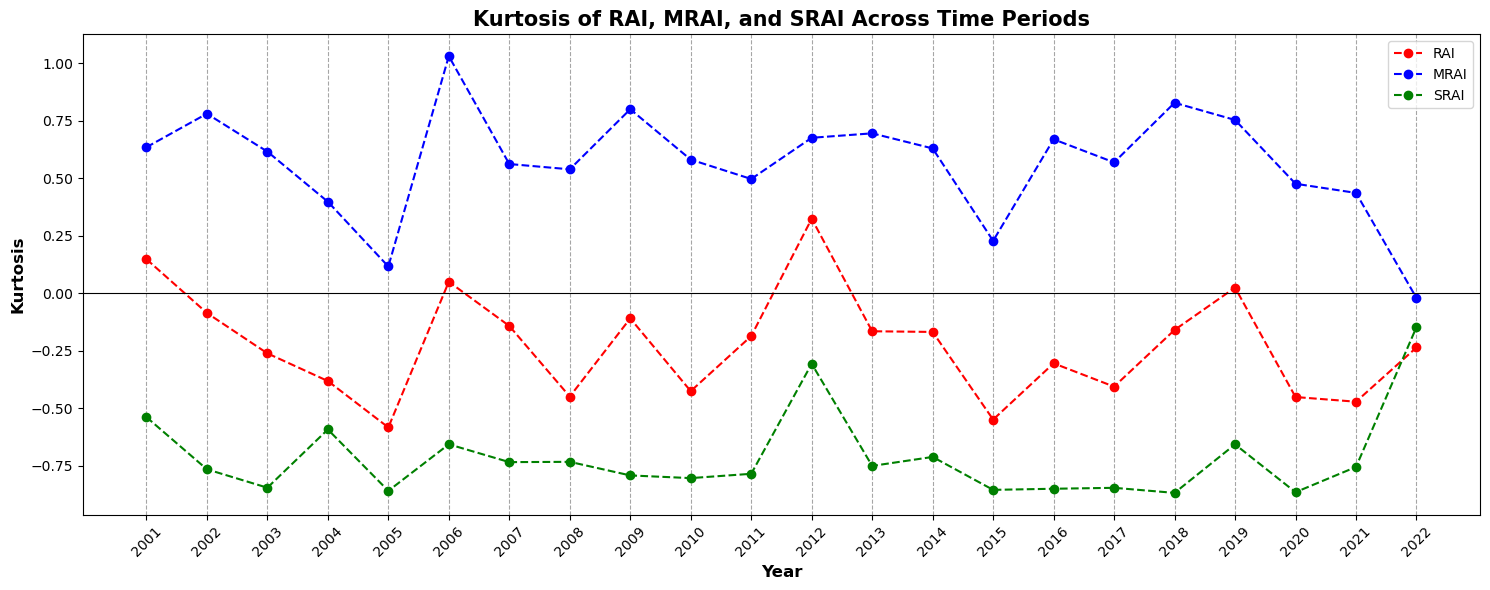

In [82]:

# Step 1: Load the data from the CSV file
file_path = os.path.join('Data', 'anomalyAllnew.csv')
data = pd.read_csv(file_path)

# Step 2: Filter data for the years between 2001 and 2022
years = list(range(2001, 2023))
filtered_data = data[data['Year'].isin(years)]

# Prepare lists to store kurtosis results
kurtosis_results = {
    'Year': years,
    'K-RAI': [],
    'K-MRAI': [],
    'K-SRAI': []
}

# Step 3: Compute kurtosis for each distribution in each year
for year in years:
    year_data = filtered_data[filtered_data['Year'] == year]
    
    # Retrieve each distribution and drop NaN values
    pre24h_RAI = year_data['pre24h_RAI'].dropna()
    pre24h_MRAI = year_data['pre24h_MRAI'].dropna()
    pre24h_SRAI = year_data['pre24h_SRAI'].dropna()
    
    # Compute kurtosis and append results
    kurtosis_results['K-RAI'].append(kurtosis(pre24h_RAI)+ 1)
    kurtosis_results['K-MRAI'].append(kurtosis(pre24h_MRAI)+ 1)
    kurtosis_results['K-SRAI'].append(kurtosis(pre24h_SRAI)+ 1)
    
# Step 4: Save results to CSV in the "Outputs" folder
output_folder = "Outputs"
os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist
output_path = os.path.join(output_folder, "kurtosis_output.csv")
kurtosis_df = pd.DataFrame(kurtosis_results)
kurtosis_df.to_csv(output_path, index=False)

print(f"Kurtosis values saved to {output_path}")

# Step 5: Plot the results
plt.figure(figsize=(15, 6))

plt.plot(kurtosis_df['Year'], kurtosis_df['K-RAI'], color='red', marker='o', label='RAI', linestyle='--', linewidth=1.5,)
plt.plot(kurtosis_df['Year'], kurtosis_df['K-MRAI'], color='blue', marker='o', label='MRAI', linestyle='--', linewidth=1.5,)
plt.plot(kurtosis_df['Year'], kurtosis_df['K-SRAI'], color='green', marker='o', label='SRAI', linestyle='--', linewidth=1.5,)

# Customize the plot
plt.xlabel("Year", fontweight='bold', fontsize=12)
plt.ylabel("Kurtosis", fontweight='bold', fontsize=12)
plt.title("Kurtosis of RAI, MRAI, and SRAI Across Time Periods", fontweight='bold', fontsize=15)
plt.legend()

# Set x-axis ticks for each year and add gridlines for each year
plt.xticks(kurtosis_df['Year'], rotation=45)  # Rotate for readability if necessary
plt.grid(True, which='both', axis='x', linestyle='--', color='grey', alpha=0.7)

# Add a solid black line at y=0
plt.axhline(0, color='black', linestyle='-', linewidth=0.8)

# Adjust layout to avoid overlap
plt.tight_layout()

# Save or display the plot
# plt.savefig("OutputPlots/f_Kurtosis")

# Display the plot
plt.show()


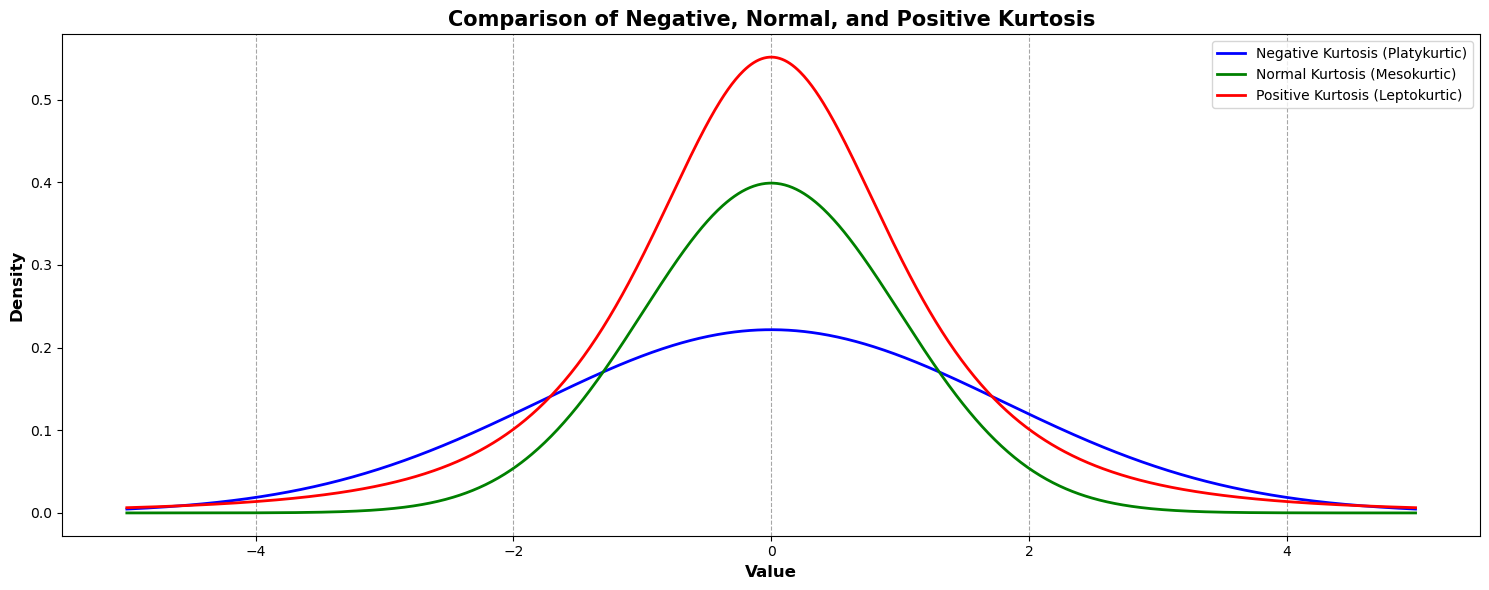

In [92]:

# Generate x values
x = np.linspace(-5, 5, 1000)

# Define probability density functions for the three types of kurtosis
# Platykurtic (negative kurtosis) - a normal distribution with a wider spread
y_negative_kurtosis = norm.pdf(x, loc=0, scale=1.8)

# Mesokurtic (normal kurtosis) - standard normal distribution
y_normal_kurtosis = norm.pdf(x, loc=0, scale=1)

# Leptokurtic (positive kurtosis) - t-distribution with heavy tails (more peaked)
y_positive_kurtosis = t.pdf(x, df=3) * 1.5

# Plot all three curves
plt.figure(figsize=(15, 6))
plt.plot(x, y_negative_kurtosis, label='Negative Kurtosis (Platykurtic)', color='blue', linewidth=2)
plt.plot(x, y_normal_kurtosis, label='Normal Kurtosis (Mesokurtic)', color='green', linewidth=2)
plt.plot(x, y_positive_kurtosis, label='Positive Kurtosis (Leptokurtic)', color='red', linewidth=2)

# Add labels and title
plt.xlabel('Value', fontweight='bold', fontsize=12)
plt.ylabel('Density', fontweight='bold', fontsize=12)
plt.title('Comparison of Negative, Normal, and Positive Kurtosis', fontweight='bold', fontsize=15)
plt.legend()
plt.grid(True, which='both', axis='x', linestyle='--', color='grey', alpha=0.7)

# Adjust layout to avoid overlap
plt.tight_layout()

# Save or display the plot
# plt.savefig("OutputPlots/f_Kurtosis_Shape")

# Show the plot
plt.show()


### **Index vs Precipitation (MRAI/RAI)**

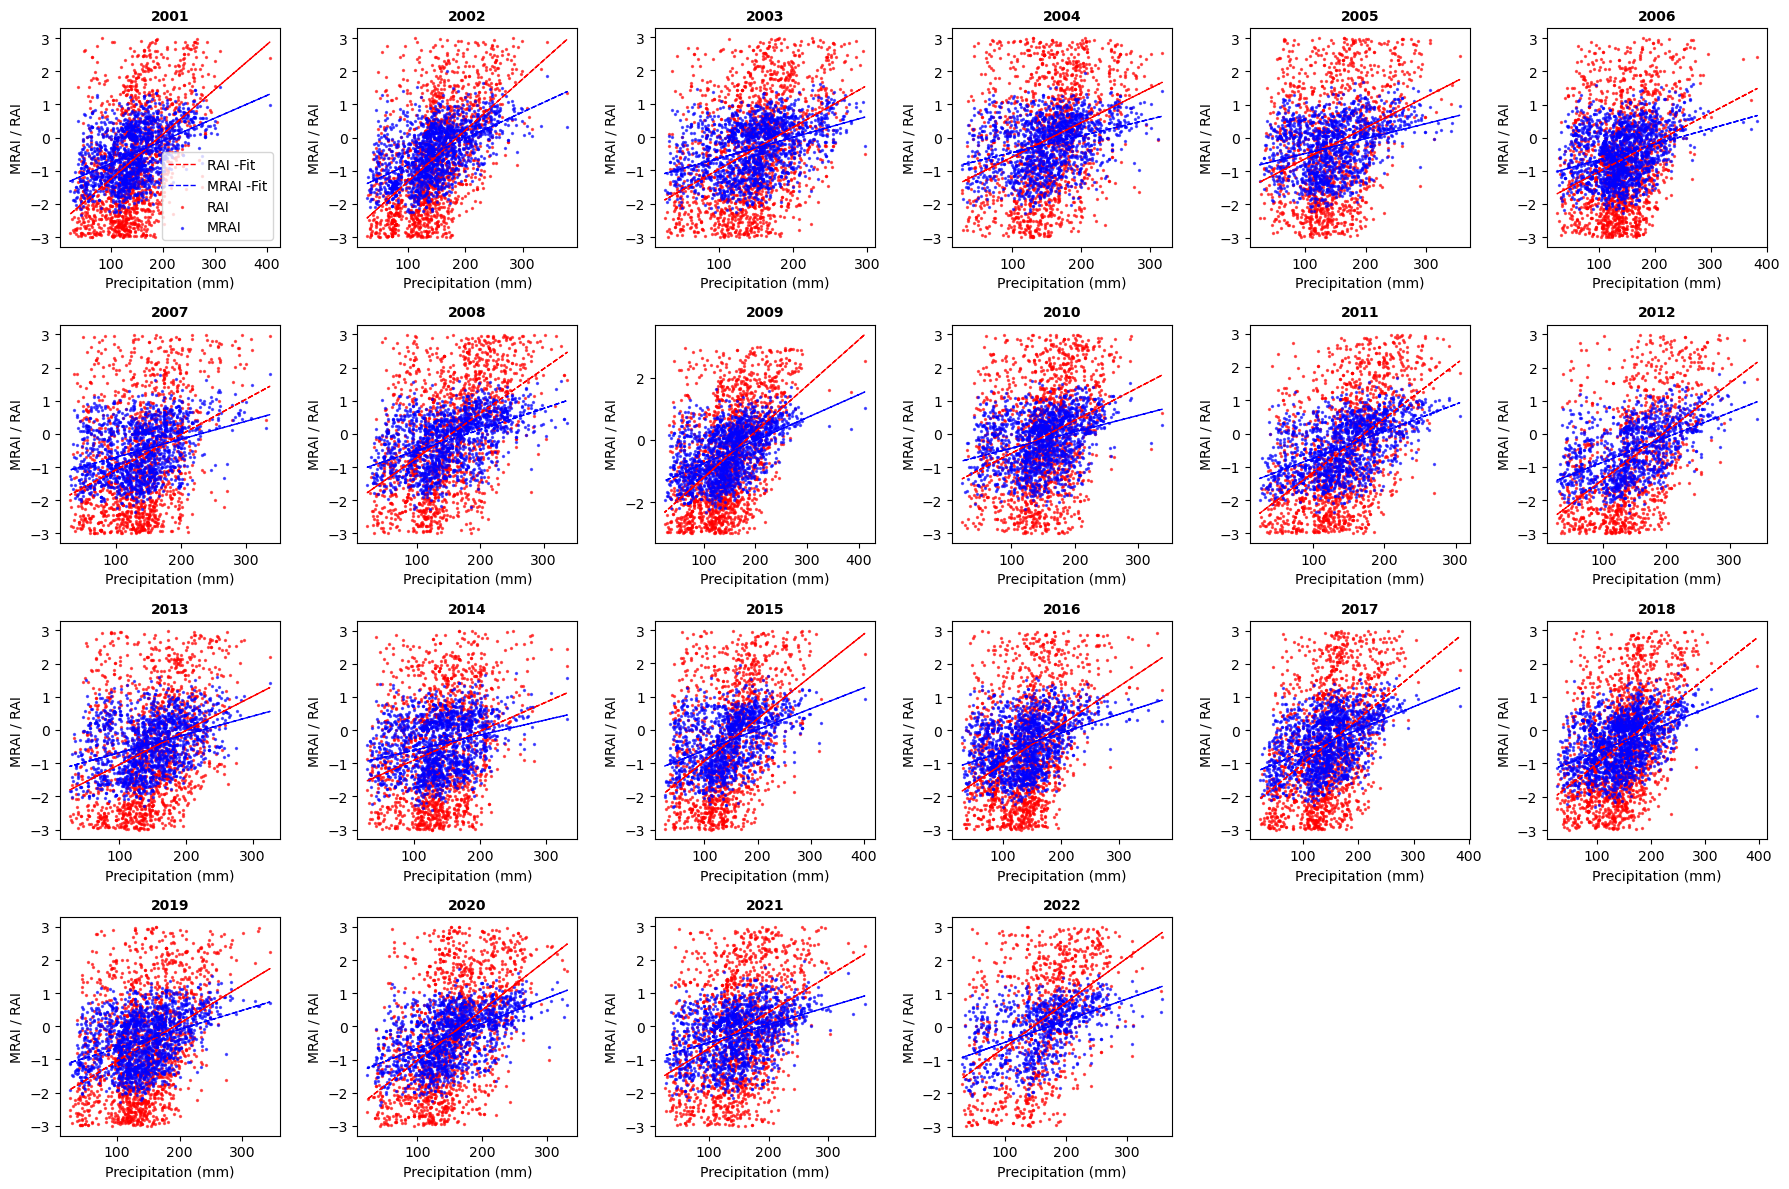

Correlation coefficients saved to Outputs\R_RAI_MRAI.csv


In [62]:

# Step 1: Load the data from the CSV file
file_path = os.path.join('Data', 'anomalyAllnew.csv')
data = pd.read_csv(file_path)

# Step 2: Filter data for the years between 2001 and 2022
years = list(range(2001, 2023))
filtered_data = data[data['Year'].isin(years)]

# Create Results folder if it doesn't exist
results_dir = os.path.join('Outputs')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Define the number of rows and columns for subplots
num_years = len(years)
fig, axs = plt.subplots(4, 6, figsize=(18, 12))  # 4 rows, 6 columns for 22 years
axs = axs.flatten()

# Lists to store the correlation coefficients
year_values = []
r1_values = []
r2_values = []

# Function to plot best-fit line and label it
def plot_best_fit(ax, x, y, color, label):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    ax.plot(x, slope * x + intercept, color=color, linestyle='--', lw=1, label=f'{label} -Fit')
    return r_value

# Step 3: Plot scatter plots and compute correlations for each year
for i, year in enumerate(years):
    year_data = filtered_data[filtered_data['Year'] == year]
    
    # Get the required fields and drop missing values
    pre24h = year_data['pre24h'].dropna()
    pre24h_MRAI = year_data['pre24h_MRAI'].dropna()
    pre24h_RAI = year_data['pre24h_RAI'].dropna()
    
    # Ensure all fields have the same index (align rows by index)
    merged_data = pd.DataFrame({'pre24h': pre24h, 'pre24h_MRAI': pre24h_MRAI, 'pre24h_RAI': pre24h_RAI}).dropna()
    
    # Filter out values where "pre24h_RAI" or "pre24h_MRAI" touch +3 or -3
    merged_data = merged_data[(merged_data['pre24h_RAI'] < 3) & (merged_data['pre24h_RAI'] > -3)]
    merged_data = merged_data[(merged_data['pre24h_MRAI'] < 3) & (merged_data['pre24h_MRAI'] > -3)]
    
    # Extract the filtered values
    pre24h = merged_data['pre24h'].values
    pre24h_RAI = merged_data['pre24h_RAI'].values
    pre24h_MRAI = merged_data['pre24h_MRAI'].values
    
    # Scatter plot
    ax = axs[i]
    
    ax.scatter(pre24h, pre24h_RAI, color='red', label='RAI', alpha=0.6, marker='o', s=2)
    ax.scatter(pre24h, pre24h_MRAI, color='blue', label='MRAI', alpha=0.6, marker='o', s=2)
    
    # Add best-fit lines and label them
    r1 = plot_best_fit(ax, pre24h, pre24h_RAI, 'red', 'RAI')
    r2 = plot_best_fit(ax, pre24h, pre24h_MRAI, 'blue', 'MRAI')
    
    # Store the correlation values
    year_values.append(year)
    r1_values.append(r1)
    r2_values.append(r2)
    
    # Set titles and labels
    ax.set_title(f'{year}', fontweight='bold', fontsize=10)
    ax.set_xlabel('Precipitation (mm)', fontweight='light', fontsize=10)
    ax.set_ylabel('MRAI / RAI', fontweight='light', fontsize=10)
    
    # Add legend only for the first plot
    if i == 0:
        ax.legend(loc='lower right')

# Remove any unused subplots
for j in range(num_years, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig("OutputPlots/g_R_RAI_MRAI")
plt.show()

# Step 4: Save the correlation coefficients to a CSV file
output_file = os.path.join(results_dir, 'R_RAI_MRAI.csv')
correlation_df = pd.DataFrame({
    'Year': year_values,
    'R1': r1_values,  # Correlation between pre24h and pre24h_RAI
    'R2': r2_values   # Correlation between pre24h and pre24h_MRAI
})

correlation_df.to_csv(output_file, index=False)
print(f"Correlation coefficients saved to {output_file}")


### **Index vs Precipitation (SRAI/RAI)**

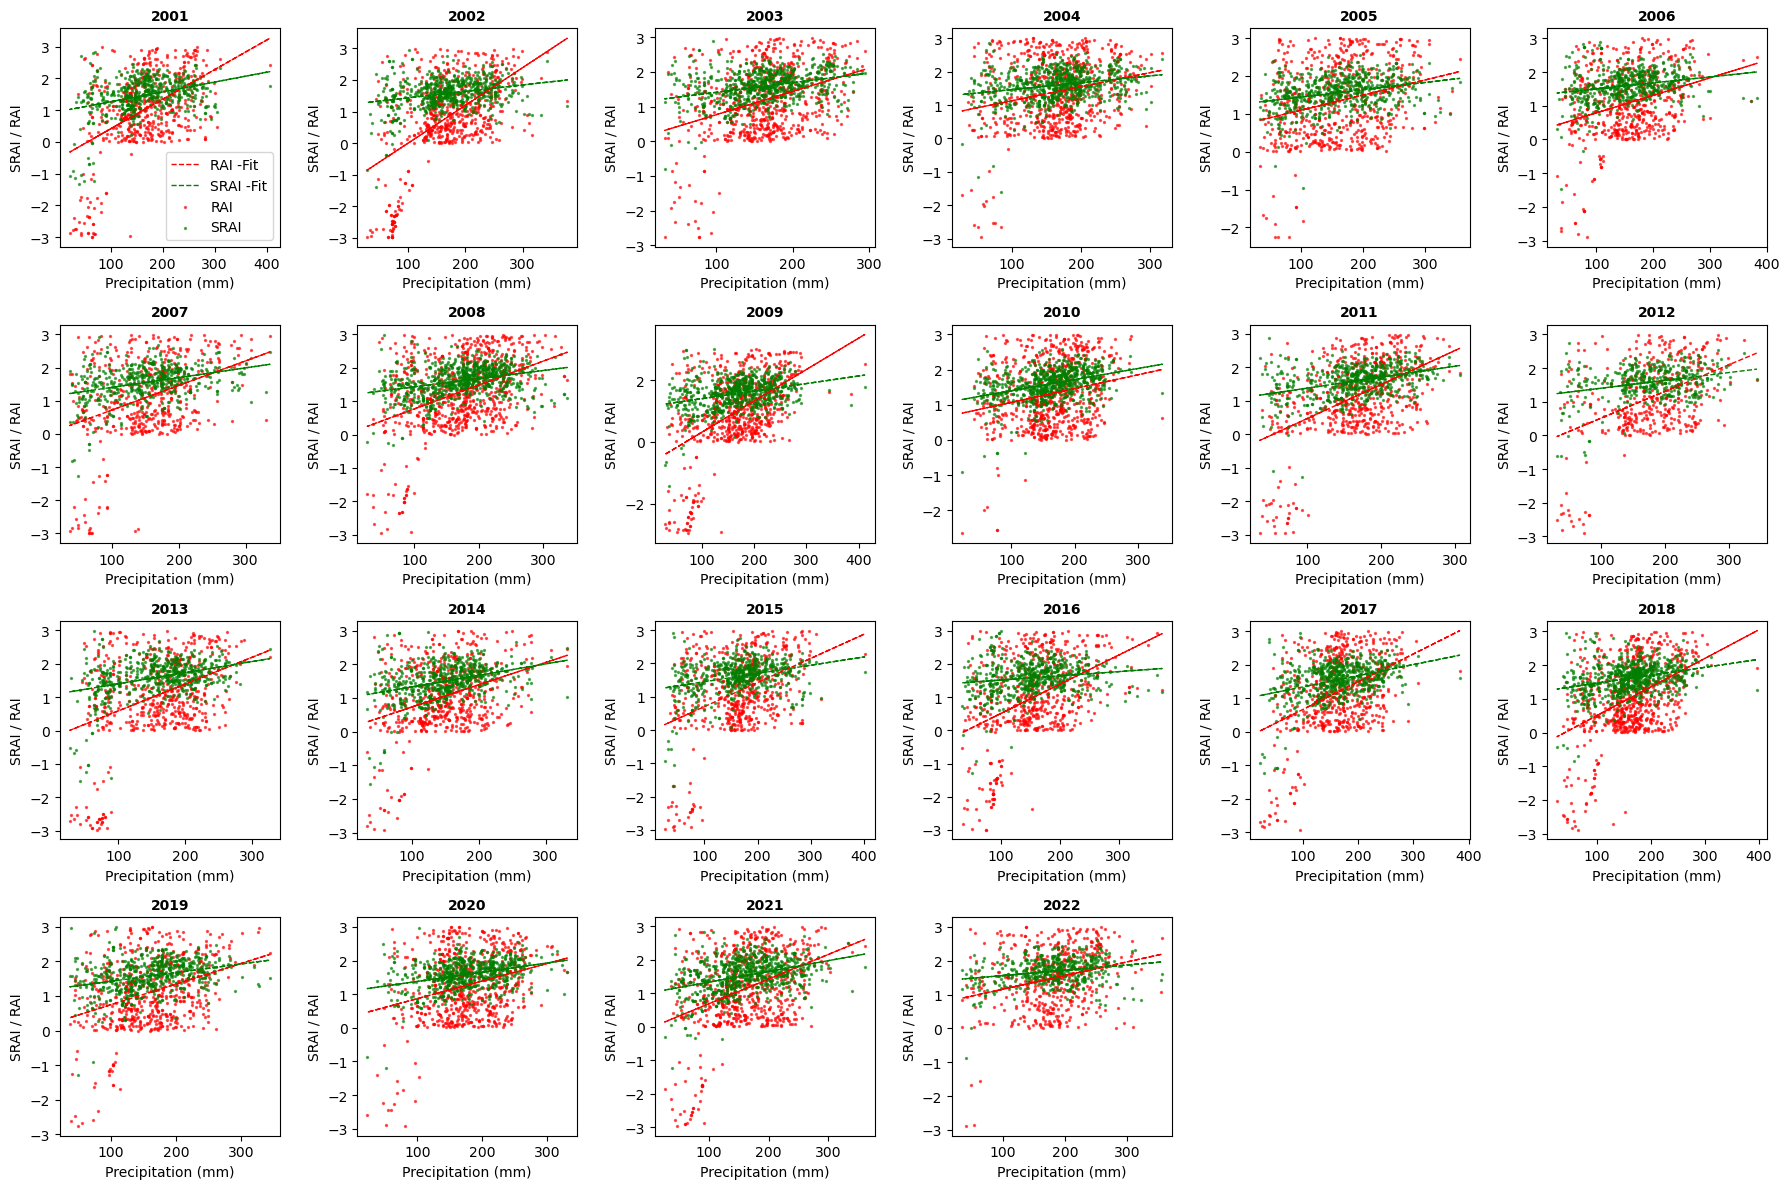

Correlation coefficients saved to Outputs\R_RAI_SRAI.csv


In [64]:

# Step 1: Load the data from the CSV file
file_path = os.path.join('Data', 'anomalyAllnew.csv')
data = pd.read_csv(file_path)

# Step 2: Filter data for the years between 2001 and 2022
years = list(range(2001, 2023))
filtered_data = data[data['Year'].isin(years)]

# Create Results folder if it doesn't exist
results_dir = os.path.join('Outputs')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Define the number of rows and columns for subplots
num_years = len(years)
fig, axs = plt.subplots(4, 6, figsize=(18, 12))  # 4 rows, 6 columns for 22 years
axs = axs.flatten()

# Lists to store the correlation coefficients
year_values = []
r1_values = []
r2_values = []

# Function to plot best-fit line and label it
def plot_best_fit(ax, x, y, color, label):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    ax.plot(x, slope * x + intercept, color=color, linestyle='--', lw=1, label=f'{label} -Fit')
    return r_value

# Step 3: Plot scatter plots and compute correlations for each year
for i, year in enumerate(years):
    year_data = filtered_data[filtered_data['Year'] == year]
    
    # Get the required fields and drop missing values
    pre24h = year_data['pre24h'].dropna()
    pre24h_MRAI = year_data['pre24h_SRAI'].dropna()
    pre24h_RAI = year_data['pre24h_RAI'].dropna()
    
    # Ensure all fields have the same index (align rows by index)
    merged_data = pd.DataFrame({'pre24h': pre24h, 'pre24h_SRAI': pre24h_MRAI, 'pre24h_RAI': pre24h_RAI}).dropna()
    
    # Filter out values where "pre24h_RAI" or "pre24h_MRAI" touch +3 or -3
    merged_data = merged_data[(merged_data['pre24h_RAI'] < 3) & (merged_data['pre24h_RAI'] > -3)]
    merged_data = merged_data[(merged_data['pre24h_SRAI'] < 3) & (merged_data['pre24h_SRAI'] > -3)]
    
    # Extract the filtered values
    pre24h = merged_data['pre24h'].values
    pre24h_RAI = merged_data['pre24h_RAI'].values
    pre24h_MRAI = merged_data['pre24h_SRAI'].values
    
    # Scatter plot
    ax = axs[i]
    
    ax.scatter(pre24h, pre24h_RAI, color='red', label='RAI', alpha=0.6, marker='o', s=2)
    ax.scatter(pre24h, pre24h_MRAI, color='green', label='SRAI', alpha=0.6, marker='o', s=2)
    
    # Add best-fit lines and label them
    r1 = plot_best_fit(ax, pre24h, pre24h_RAI, 'red', 'RAI')
    r2 = plot_best_fit(ax, pre24h, pre24h_MRAI, 'green', 'SRAI')
    
    # Store the correlation values
    year_values.append(year)
    r1_values.append(r1)
    r2_values.append(r2)
    
    # Set titles and labels
    ax.set_title(f'{year}', fontweight='bold', fontsize=10)
    ax.set_xlabel('Precipitation (mm)', fontweight='light', fontsize=10)
    ax.set_ylabel('SRAI / RAI', fontweight='light', fontsize=10)
    
    # Add legend only for the first plot
    if i == 0:
        ax.legend(loc='lower right')

# Remove any unused subplots
for j in range(num_years, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig("OutputPlots/g1_R_RAI_SRAI")
plt.show()

# Step 4: Save the correlation coefficients to a CSV file
output_file = os.path.join(results_dir, 'R_RAI_SRAI.csv')
correlation_df = pd.DataFrame({
    'Year': year_values,
    'R1': r1_values,  # Correlation between pre24h and pre24h_RAI
    'R2': r2_values   # Correlation between pre24h and pre24h_SRAI
})

correlation_df.to_csv(output_file, index=False)
print(f"Correlation coefficients saved to {output_file}")


#### **Average Index (All Stations)**

In [67]:
# Step 1: Load the data from the CSV file
file_path = os.path.join('Data', 'anomalyAllnew.csv')
data = pd.read_csv(file_path)

# Step 2: Filter data for the years between 2001 and 2022
years = list(range(2001, 2023))
filtered_data = data[data['Year'].isin(years)]

# Step 3: Calculate average anomaly for each unique ID
average_anomalies = filtered_data.groupby('ID').agg({
    'Lat': 'first',
    'Lon': 'first',
    'pre24h_RAI': 'mean',
    'pre24h_MRAI': 'mean',
    'pre24h_SRAI': 'mean'
}).reset_index()

# Rename the column 
average_anomalies.rename(columns={'pre24h_RAI': 'RAI_avg', 'pre24h_MRAI': 'MRAI_avg', 'pre24h_SRAI': 'SRAI_avg'}, inplace=True)

# # Step 4: Scale the 'Average' to percentage
# average_anomalies['RAI_avg'] = average_anomalies['RAI_avg'] * 100
# average_anomalies['MRAI_avg'] = average_anomalies['MRAI_avg'] * 100
# average_anomalies['SRAI_avg'] = average_anomalies['SRAI_avg'] * 100

# Step 5: Create a directory to save results if it doesn't exist
output_dir = "Outputs"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Step 6: Save the results to a CSV file
output_file_path = os.path.join(output_dir, 'AverageAnomaly.csv')
average_anomalies.to_csv(output_file_path, index=False)

print("Average anomaly statistics with scaled values saved to:", output_file_path)


Average anomaly statistics with scaled values saved to: Outputs\AverageAnomaly.csv


#### **Median Index (All Stations)**

In [66]:
# Step 1: Load the data from the CSV file
file_path = os.path.join('Data', 'anomalyAllnew.csv')
data = pd.read_csv(file_path)

# Step 2: Filter data for the years between 2001 and 2022
years = list(range(2001, 2023))
filtered_data = data[data['Year'].isin(years)]

# Step 3: Calculate average anomaly for each unique ID
average_anomalies = filtered_data.groupby('ID').agg({
    'Lat': 'first',
    'Lon': 'first',
    'pre24h_RAI': 'median',
    'pre24h_MRAI': 'median',
    'pre24h_SRAI': 'median'
}).reset_index()

# Rename the column 
average_anomalies.rename(columns={'pre24h_RAI': 'RAI_med', 'pre24h_MRAI': 'MRAI_med', 'pre24h_SRAI': 'SRAI_med'}, inplace=True)

# # Step 4: Scale the 'Average' to percentage
# average_anomalies['RAI_med'] = average_anomalies['RAI_med'] * 100
# average_anomalies['MRAI_med'] = average_anomalies['MRAI_med'] * 100
# average_anomalies['SRAI_amed'] = average_anomalies['SRAI_med'] * 100

# Step 5: Create a directory to save results if it doesn't exist
output_dir = "Outputs"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Step 6: Save the results to a CSV file
output_file_path = os.path.join(output_dir, 'MedianAnomaly.csv')
average_anomalies.to_csv(output_file_path, index=False)

print("Average anomaly statistics with scaled values saved to:", output_file_path)


Average anomaly statistics with scaled values saved to: Outputs\MedianAnomaly.csv
